In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import h5py
from scipy.stats import norm
import torch
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torch import nn, optim
import scipy.io as sio
import torch.nn.functional as F
# import pandas as pd
import datetime
import os
# import readligo as rl
# from gwpy.timeseries import TimeSeries
import math
import random

import copy

In [2]:
epochs = 200
rTrain = 0.7;
rTest = 0.2;
rValidation = 0.1
# input_vector_length = 100
batch_size = 32
num_bins = 40
coef_delta = 0

# Definition of the structure

In [3]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=2, out_channels=50, kernel_size=2, stride=1, padding=1)# 100
        self.batch1 = nn.BatchNorm1d(num_features=50)
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=4, return_indices=True)
        
        self.conv2 = nn.Conv1d(in_channels=50, out_channels=20, kernel_size=2, stride=1, padding=1)# 40
        self.batch2 = nn.BatchNorm1d(num_features=20)
        self.act2 = nn.ReLU()
#         self.pool2 = nn.MaxUnpool1d(kernel_size=4)
        
        self.conv3 = nn.Conv1d(in_channels=20, out_channels=50, kernel_size=2, stride=1, padding=1)# 100
        self.batch3 = nn.BatchNorm1d(num_features=50)
        self.act3 = nn.ReLU()
        self.pool3 = nn.MaxUnpool1d(kernel_size=4)
        
        self.conv4 = nn.Conv1d(in_channels=50, out_channels=1, kernel_size=2, padding=1)
        self.final = nn.Tanh()

    def forward(self, x):
#         print(x.shape)
        x = self.conv1(x);
        x = self.batch1(x);
        x = self.act1(x);
        x, indices = self.pool1(x);
#         print(x.shape)
#         x = self.pool1(self.act1(self.batch1(self.conv1(x))))
        encoded = self.act2(self.conv2(x))
#         print(encoded.shape)
        
        x = self.conv3(encoded)
        x = self.batch3(x);
        x = self.act3(x);
#         print(x.shape)
        x = self.pool3(x, indices);

#         x = self.final(self.conv4(x))
        x = self.conv4(x)

        return encoded, x

## Below is the model for Supervised Learning. We want to investigate its performance for glitch exclusion

In [3]:
class WaveletCNNSL(nn.Module):
    
    def __init__(
        self, 
        num_ifos: int,
        c_depth: int=8, 
        n_chann: int=64, 
        l1: int=1024, 
        l2: int=128,
        lx: int=200
    ):
        
        super(WaveletCNNSL, self).__init__()
        
        self.c_depth = c_depth
        self.n_chann = n_chann
        
        self.cap_norm = nn.GroupNorm(num_ifos, num_ifos)
        
        self.Conv_In = nn.Conv1d(
                in_channels=num_ifos, 
                out_channels=self.n_chann, 
                kernel_size=1
            )
        
        self.Conv_Out = nn.Conv1d(
                in_channels=self.n_chann, 
                out_channels=1, 
                kernel_size=1
            )
        
        self.body_norm = nn.GroupNorm(4 ,n_chann)
        self.end_norm = nn.BatchNorm1d(1)
        
        self.WaveNet_layers = nn.ModuleList()
        
        
        for i in range(self.c_depth):

            conv_layer = nn.Conv1d(
                in_channels=self.n_chann, 
                out_channels=self.n_chann,
                kernel_size=2,
                dilation=2**i
            )
            
            self.WaveNet_layers.append(conv_layer)
        
        
        # self.L1 = nn.Linear(8192-2**c_depth, l1)
        
        # Consider replacing other batch normalizatoin layers with other nor method
        # Because batch norm are baised by the population of the CCSN rate in one batch 
        # This may produce overfitting model and will not be able to found at test phase
        # Question: Will we be able to figure out the side effect at infereceing phase?
        
        self.L1_norm = nn.BatchNorm1d(200-2**c_depth+1)
        self.L1 = nn.Linear(200-2**c_depth+1, l1)
        self.L2_norm = nn.BatchNorm1d(l1)
        self.L2 = nn.Linear(l1, l2)
        self.L3_norm = nn.BatchNorm1d(l2)
        self.L3 = nn.Linear(l2, 1)


        nn.init.kaiming_normal_(self.Conv_In.weight)
        nn.init.kaiming_normal_(self.Conv_Out.weight)
        nn.init.constant_(self.Conv_In.bias, 0.001)
        nn.init.constant_(self.Conv_Out.bias, 0.001)

        # Initialize all the convolutional layer in between
        for conv_layer in self.WaveNet_layers:
            nn.init.kaiming_normal_(conv_layer.weight)
            nn.init.constant_(conv_layer.bias, 0.001)

        nn.init.kaiming_uniform_(self.L1.weight)
        nn.init.kaiming_uniform_(self.L2.weight)
        nn.init.constant_(self.L1.bias, 0.001)
        nn.init.constant_(self.L2.bias, 0.001)
        
    def forward(self, x):

        x = self.cap_norm(x)
        x = self.Conv_In(x)
        x = F.relu(x)
        
        # x = self.norm(x)
        
        for what_are_u_wavin_at in self.WaveNet_layers:
            x = self.body_norm(x)
            x = what_are_u_wavin_at(x)
            x = F.relu(x)
            
        x = self.Conv_Out(x)
        x = F.relu(x)
        x = self.end_norm(x)
        
        x = torch.flatten(x, 1)
        
        
        x = F.relu(self.L1(x))
        x = self.L2_norm(x)
        x = F.relu(self.L2(x))
        x = self.L3_norm(x)
        # x = F.softmax(self.L3(x), dim = 1)
        x = self.L3(x)
        
        return x

## Below is the model for AE. We don't know whether this is suitable for AE case. 

### One channel for DNN

In [4]:
class WaveletCNNAE(nn.Module):
    
    def __init__(
        self, 
        num_ifos: int,
        c_depth: int=8, 
        n_chann: int=64, 
        l1: int=1024, 
        l2: int=128
        # lx: int=200
    ):
        
        super(WaveletCNNAE, self).__init__()
        
        self.c_depth = c_depth
        self.n_chann = n_chann
        
        self.cap_norm = nn.GroupNorm(num_ifos, num_ifos)
        
        self.Conv_In_encode = nn.Conv1d(
                in_channels=num_ifos, 
                out_channels=self.n_chann, 
                kernel_size=1
            )
        
        self.Conv_Out_encode = nn.Conv1d(
                in_channels=self.n_chann, 
                out_channels=1, 
                kernel_size=1
            )
        
        self.Conv_In_decode = nn.Conv1d(
                in_channels=1, 
                out_channels=self.n_chann, 
                kernel_size=1
            )
        
        self.Conv_Out_decode = nn.Conv1d(
                in_channels=self.n_chann, 
                out_channels=num_ifos, 
                kernel_size=1
            )
        
        self.body_norm_encode = nn.GroupNorm(4 ,n_chann)
        self.body_norm_decode = nn.GroupNorm(4 ,n_chann)
        self.end_norm_encode = nn.BatchNorm1d(1)
        self.end_norm_decode = nn.BatchNorm1d(1)
        
        self.WaveNet_layers_encode = nn.ModuleList()
        self.WaveNet_layers_decode = nn.ModuleList()
        
        
        for i in range(self.c_depth):

            conv_layer = nn.Conv1d(
                in_channels=self.n_chann, 
                out_channels=self.n_chann,
                kernel_size=2,
                dilation=2**i
            )
            
            self.WaveNet_layers_encode.append(conv_layer)
            
        for i in range(self.c_depth):

            conv_layer = nn.Conv1d(
                in_channels=self.n_chann, 
                out_channels=self.n_chann,
                kernel_size=2,
                dilation=2**i
            )
            
            self.WaveNet_layers_decode.append(conv_layer)
        
        
        self.Padding_layer = nn.ZeroPad1d(2**c_depth - 1)
                
        # self.L1 = nn.Linear(8192-2**c_depth, l1)
        
        # Consider replacing other batch normalizatoin layers with other nor method
        # Because batch norm are baised by the population of the CCSN rate in one batch 
        # This may produce overfitting model and will not be able to found at test phase
        # Question: Will we be able to figure out the side effect at infereceing phase?
        
        self.L1_norm = nn.BatchNorm1d(200-2**c_depth + 1)
        self.L1 = nn.Linear(200-2**c_depth + 1, l1)
        self.L2_norm = nn.BatchNorm1d(l1)
        self.L2 = nn.Linear(l1, l2)
        # self.L3_norm = nn.BatchNorm1d(l2)
        # self.L3 = nn.Linear(l2, 1)
        self.L4_norm = nn.BatchNorm1d(l2)
        self.L4 = nn.Linear(l2, l1)
        self.L5_norm = nn.BatchNorm1d(l1)
        self.L5 = nn.Linear(l1, 200-2**c_depth + 1)

        nn.init.kaiming_normal_(self.Conv_In_encode.weight)
        nn.init.kaiming_normal_(self.Conv_Out_encode.weight)
        nn.init.constant_(self.Conv_In_encode.bias, 0.001)
        nn.init.constant_(self.Conv_Out_encode.bias, 0.001)
        
        nn.init.kaiming_normal_(self.Conv_In_decode.weight)
        nn.init.kaiming_normal_(self.Conv_Out_decode.weight)
        nn.init.constant_(self.Conv_In_decode.bias, 0.001)
        nn.init.constant_(self.Conv_Out_decode.bias, 0.001)

        # Initialize all the convolutional layer in between
        for conv_layer in self.WaveNet_layers_encode:
            nn.init.kaiming_normal_(conv_layer.weight)
            nn.init.constant_(conv_layer.bias, 0.001)
            
        for conv_layer in self.WaveNet_layers_decode:
            nn.init.kaiming_normal_(conv_layer.weight)
            nn.init.constant_(conv_layer.bias, 0.001)    

        nn.init.kaiming_uniform_(self.L1.weight)
        nn.init.kaiming_uniform_(self.L2.weight)
        nn.init.constant_(self.L1.bias, 0.001)
        nn.init.constant_(self.L2.bias, 0.001)
        
        nn.init.kaiming_uniform_(self.L4.weight)
        nn.init.kaiming_uniform_(self.L5.weight)
        nn.init.constant_(self.L4.bias, 0.001)
        nn.init.constant_(self.L5.bias, 0.001)
        
    def encode(self, x):
        
        x = self.cap_norm(x)
        x = self.Conv_In_encode(x)
        x = F.relu(x)
        
        # x = self.norm(x)
        
        for what_are_u_wavin_at in self.WaveNet_layers_encode:
            x = self.body_norm_encode(x)
            x = what_are_u_wavin_at(x)
            x = F.relu(x)
            
        # print(x.shape)
        x = self.Conv_Out_encode(x)
        x = F.relu(x)
        x = self.end_norm_encode(x)
        x = torch.flatten(x, 1)
        
        # print(x.shape)
        
        x = F.relu(self.L1(x))
        # print(x.shape)
        x = self.L2_norm(x)
        # x = F.relu(self.L2(x))
        # x = self.L3_norm(x)
        # x = F.softmax(self.L3(x), dim = 1)
        # x = self.L3(x)
        x = self.L2(x)
        x = F.relu(x)
        # print('Encoder done')
        
        return x
    
    def decode(self, x):
        # print(x.shape)
        x = self.L4_norm(x)
        # print(x.shape)
        x = F.relu(self.L4(x))
        # print(x.shape)
        x = self.L5_norm(x)
        # print(x.shape)
        # x = F.relu(self.L2(x))
        # x = self.L3_norm(x)
        # x = F.softmax(self.L3(x), dim = 1)
        # x = self.L3(x)
        x = F.relu(self.L5(x))
        # print(x.shape)
        # print('DNN done')
        
        x = self.Padding_layer(x)
        
        x = torch.unsqueeze(x,1)

        # print(x.shape)
        
        # x = self.cap_norm(x)
        x = self.Conv_In_decode(x)
        x = F.relu(x)
        
        # x = self.norm(x)
        
        for what_are_u_wavin_at in self.WaveNet_layers_decode:
            # print(x.shape)
            x = self.body_norm_decode(x)
            x = what_are_u_wavin_at(x)
            x = F.relu(x)
        
        # print(x.shape)
        # print('CNN done')
        
        x = self.Conv_Out_decode(x)
        # print(x.shape)
        x = F.tanh(x)
        # print(x.shape)
        # x = self.end_norm_decode(x)
        
        # x = torch.flatten(x, 1)
        
        
        return x
    
    def forward(self,x):
        return self.decode(self.encode(x))

### Multi-channel for DNN

In [5]:
class WaveletCNNAEMC(nn.Module):
    
    def __init__(
        self, 
        num_ifos: int,
        c_depth: int=8, 
        n_chann: int=64, 
        l1: int=1024, 
        l2: int=128
        # lx: int=200
    ):
        
        super(WaveletCNNAEMC, self).__init__()
        
        self.c_depth = c_depth
        self.n_chann = n_chann
        
        self.cap_norm = nn.GroupNorm(num_ifos, num_ifos)
        
        self.Conv_In_encode = nn.Conv1d(
                in_channels=num_ifos, 
                out_channels=self.n_chann, 
                kernel_size=1
            )
        
        self.Conv_Out_encode = nn.Conv1d(
                in_channels=self.n_chann, 
                out_channels=self.n_chann, 
                kernel_size=1
            )
        
        self.Conv_In_decode = nn.Conv1d(
                in_channels=self.n_chann, 
                out_channels=self.n_chann, 
                kernel_size=1
            )
        
        self.Conv_Out_decode = nn.Conv1d(
                in_channels=self.n_chann, 
                out_channels=num_ifos, 
                kernel_size=1
            )
        
        self.body_norm_encode = nn.GroupNorm(4 ,n_chann)
        self.body_norm_decode = nn.GroupNorm(4 ,n_chann)
        self.end_norm_encode = nn.BatchNorm1d(n_chann)
        self.end_norm_decode = nn.BatchNorm1d(1)
        
        self.WaveNet_layers_encode = nn.ModuleList()
        self.WaveNet_layers_decode = nn.ModuleList()
        
        
        for i in range(self.c_depth):

            conv_layer = nn.Conv1d(
                in_channels=self.n_chann, 
                out_channels=self.n_chann,
                kernel_size=2,
                dilation=2**i
            )
            
            self.WaveNet_layers_encode.append(conv_layer)
            
        for i in range(self.c_depth):

            conv_layer = nn.Conv1d(
                in_channels=self.n_chann, 
                out_channels=self.n_chann,
                kernel_size=2,
                dilation=2**i
            )
            
            self.WaveNet_layers_decode.append(conv_layer)
        
        
        self.Padding_layer = nn.ZeroPad1d(2**c_depth - 1)
                
        # self.L1 = nn.Linear(8192-2**c_depth, l1)
        
        # Consider replacing other batch normalizatoin layers with other nor method
        # Because batch norm are baised by the population of the CCSN rate in one batch 
        # This may produce overfitting model and will not be able to found at test phase
        # Question: Will we be able to figure out the side effect at infereceing phase?
        
        self.L1_norm = nn.BatchNorm1d(200-2**c_depth + 1)
        self.L1 = nn.Linear(200-2**c_depth + 1, l1)
        self.L2_norm = nn.BatchNorm1d(l1)
        self.L2 = nn.Linear(l1, l2)
        # self.L3_norm = nn.BatchNorm1d(l2)
        # self.L3 = nn.Linear(l2, 1)
        self.L4_norm = nn.BatchNorm1d(l2)
        self.L4 = nn.Linear(l2, l1)
        self.L5_norm = nn.BatchNorm1d(l1)
        self.L5 = nn.Linear(l1, 200-2**c_depth + 1)

        nn.init.kaiming_normal_(self.Conv_In_encode.weight)
        nn.init.kaiming_normal_(self.Conv_Out_encode.weight)
        nn.init.constant_(self.Conv_In_encode.bias, 0.001)
        nn.init.constant_(self.Conv_Out_encode.bias, 0.001)
        
        nn.init.kaiming_normal_(self.Conv_In_decode.weight)
        nn.init.kaiming_normal_(self.Conv_Out_decode.weight)
        nn.init.constant_(self.Conv_In_decode.bias, 0.001)
        nn.init.constant_(self.Conv_Out_decode.bias, 0.001)

        # Initialize all the convolutional layer in between
        for conv_layer in self.WaveNet_layers_encode:
            nn.init.kaiming_normal_(conv_layer.weight)
            nn.init.constant_(conv_layer.bias, 0.001)
            
        for conv_layer in self.WaveNet_layers_decode:
            nn.init.kaiming_normal_(conv_layer.weight)
            nn.init.constant_(conv_layer.bias, 0.001)    

        nn.init.kaiming_uniform_(self.L1.weight)
        nn.init.kaiming_uniform_(self.L2.weight)
        nn.init.constant_(self.L1.bias, 0.001)
        nn.init.constant_(self.L2.bias, 0.001)
        
        nn.init.kaiming_uniform_(self.L4.weight)
        nn.init.kaiming_uniform_(self.L5.weight)
        nn.init.constant_(self.L4.bias, 0.001)
        nn.init.constant_(self.L5.bias, 0.001)
        
    def encode(self, x):
        
        x = self.cap_norm(x)
        x = self.Conv_In_encode(x)
        x = F.relu(x)
        
        # x = self.norm(x)
        
        for what_are_u_wavin_at in self.WaveNet_layers_encode:
            x = self.body_norm_encode(x)
            x = what_are_u_wavin_at(x)
            x = F.relu(x)
            
        # print(x.shape)
        x = self.Conv_Out_encode(x)
        x = F.relu(x)
        x = self.end_norm_encode(x)
        # x = torch.flatten(x, 1)
        
        # print(x.shape)
        
        x = F.relu(self.L1(x))
        # print(x.shape)
        x = self.L2_norm(x.permute(0,2,1)).permute(0,2,1)
        # x = F.relu(self.L2(x))
        # x = self.L3_norm(x)
        # x = F.softmax(self.L3(x), dim = 1)
        # x = self.L3(x)
        x = self.L2(x)
        x = F.relu(x)
        # print('Encoder done')
        
        return x
    
    def decode(self, x):
        # print(x.shape)
        x = self.L4_norm(x.permute(0,2,1)).permute(0,2,1)
        # print(x.shape)
        x = F.relu(self.L4(x))
        # print(x.shape)
        x = self.L5_norm(x.permute(0,2,1)).permute(0,2,1)
        # print(x.shape)
        # x = F.relu(self.L2(x))
        # x = self.L3_norm(x)
        # x = F.softmax(self.L3(x), dim = 1)
        # x = self.L3(x)
        x = F.relu(self.L5(x))
        # print(x.shape)
        # print('DNN done')
        
        x = self.Padding_layer(x)
        
        # x = torch.unsqueeze(x,1)

        # print(x.shape)
        
        # x = self.cap_norm(x)
        x = self.Conv_In_decode(x)
        x = F.relu(x)
        
        # x = self.norm(x)
        
        for what_are_u_wavin_at in self.WaveNet_layers_decode:
            # print(x.shape)
            x = self.body_norm_decode(x)
            x = what_are_u_wavin_at(x)
            x = F.relu(x)
        
        # print(x.shape)
        # print('CNN done')
        
        x = self.Conv_Out_decode(x)
        # print(x.shape)
        x = F.tanh(x)
        # print(x.shape)
        # x = self.end_norm_decode(x)
        
        # x = torch.flatten(x, 1)
        
        
        return x
    
    def forward(self,x):
        return self.decode(self.encode(x))

### If there's no DNN

In [6]:
class WaveletCNNAEND(nn.Module):
    
    def __init__(
        self, 
        num_ifos: int,
        c_depth: int=8, 
        n_chann: int=64, 
        l1: int=1024, 
        l2: int=128
        # lx: int=200
    ):
        
        super(WaveletCNNAEND, self).__init__()
        
        self.c_depth = c_depth
        self.n_chann = n_chann
        
        self.cap_norm = nn.GroupNorm(num_ifos, num_ifos)
        
        self.Conv_In_encode = nn.Conv1d(
                in_channels=num_ifos, 
                out_channels=self.n_chann, 
                kernel_size=1
            )
        
        self.Conv_Out_encode = nn.Conv1d(
                in_channels=self.n_chann, 
                out_channels=self.n_chann, 
                kernel_size=1
            )
        
        self.Conv_In_decode = nn.Conv1d(
                in_channels=self.n_chann, 
                out_channels=self.n_chann, 
                kernel_size=1
            )
        
        self.Conv_Out_decode = nn.Conv1d(
                in_channels=self.n_chann, 
                out_channels=num_ifos, 
                kernel_size=1
            )
        
        self.body_norm_encode = nn.GroupNorm(4 ,n_chann)
        self.body_norm_decode = nn.GroupNorm(4 ,n_chann)
        self.end_norm_encode = nn.BatchNorm1d(n_chann)
        self.end_norm_decode = nn.BatchNorm1d(1)
        
        self.WaveNet_layers_encode = nn.ModuleList()
        self.WaveNet_layers_decode = nn.ModuleList()
        
        
        for i in range(self.c_depth):

            conv_layer = nn.Conv1d(
                in_channels=self.n_chann, 
                out_channels=self.n_chann,
                kernel_size=2,
                dilation=2**i
            )
            
            self.WaveNet_layers_encode.append(conv_layer)
            
        for i in range(self.c_depth):

            conv_layer = nn.Conv1d(
                in_channels=self.n_chann, 
                out_channels=self.n_chann,
                kernel_size=2,
                dilation=2**i
            )
            
            self.WaveNet_layers_decode.append(conv_layer)
        
        
        self.Padding_layer = nn.ZeroPad1d(2**c_depth - 1)
                
        # self.L1 = nn.Linear(8192-2**c_depth, l1)
        
        # Consider replacing other batch normalizatoin layers with other nor method
        # Because batch norm are baised by the population of the CCSN rate in one batch 
        # This may produce overfitting model and will not be able to found at test phase
        # Question: Will we be able to figure out the side effect at infereceing phase?
        
        # self.L1_norm = nn.BatchNorm1d(200-2**c_depth + 1)
        # self.L1 = nn.Linear(200-2**c_depth + 1, l1)
        # self.L2_norm = nn.BatchNorm1d(l1)
        # self.L2 = nn.Linear(l1, l2)
        # # self.L3_norm = nn.BatchNorm1d(l2)
        # # self.L3 = nn.Linear(l2, 1)
        # self.L4_norm = nn.BatchNorm1d(l2)
        # self.L4 = nn.Linear(l2, l1)
        # self.L5_norm = nn.BatchNorm1d(l1)
        # self.L5 = nn.Linear(l1, 200-2**c_depth + 1)

        nn.init.kaiming_normal_(self.Conv_In_encode.weight)
        nn.init.kaiming_normal_(self.Conv_Out_encode.weight)
        nn.init.constant_(self.Conv_In_encode.bias, 0.001)
        nn.init.constant_(self.Conv_Out_encode.bias, 0.001)
        
        nn.init.kaiming_normal_(self.Conv_In_decode.weight)
        nn.init.kaiming_normal_(self.Conv_Out_decode.weight)
        nn.init.constant_(self.Conv_In_decode.bias, 0.001)
        nn.init.constant_(self.Conv_Out_decode.bias, 0.001)

        # Initialize all the convolutional layer in between
        for conv_layer in self.WaveNet_layers_encode:
            nn.init.kaiming_normal_(conv_layer.weight)
            nn.init.constant_(conv_layer.bias, 0.001)
            
        for conv_layer in self.WaveNet_layers_decode:
            nn.init.kaiming_normal_(conv_layer.weight)
            nn.init.constant_(conv_layer.bias, 0.001)    

        # nn.init.kaiming_uniform_(self.L1.weight)
        # nn.init.kaiming_uniform_(self.L2.weight)
        # nn.init.constant_(self.L1.bias, 0.001)
        # nn.init.constant_(self.L2.bias, 0.001)
        
        # nn.init.kaiming_uniform_(self.L4.weight)
        # nn.init.kaiming_uniform_(self.L5.weight)
        # nn.init.constant_(self.L4.bias, 0.001)
        # nn.init.constant_(self.L5.bias, 0.001)
        
    def encode(self, x):
        
        x = self.cap_norm(x)
        x = self.Conv_In_encode(x)
        x = F.relu(x)
        
        # x = self.norm(x)
        
        for what_are_u_wavin_at in self.WaveNet_layers_encode:
            x = self.body_norm_encode(x)
            x = what_are_u_wavin_at(x)
            x = F.relu(x)
            
        # print(x.shape)
        x = self.Conv_Out_encode(x)
        x = F.relu(x)
        x = self.end_norm_encode(x)
        # x = torch.flatten(x, 1)
        
        # print(x.shape)
        
        # x = F.relu(self.L1(x))
        # # print(x.shape)
        # x = self.L2_norm(x.permute(0,2,1)).permute(0,2,1)
        # # x = F.relu(self.L2(x))
        # # x = self.L3_norm(x)
        # # x = F.softmax(self.L3(x), dim = 1)
        # # x = self.L3(x)
        # x = self.L2(x)
        # x = F.relu(x)
        # print('Encoder done')
        
        return x
    
    def decode(self, x):
        # print(x.shape)
        # x = self.L4_norm(x.permute(0,2,1)).permute(0,2,1)
        # # print(x.shape)
        # x = F.relu(self.L4(x))
        # # print(x.shape)
        # x = self.L5_norm(x.permute(0,2,1)).permute(0,2,1)
        # # print(x.shape)
        # # x = F.relu(self.L2(x))
        # # x = self.L3_norm(x)
        # # x = F.softmax(self.L3(x), dim = 1)
        # # x = self.L3(x)
        # x = F.relu(self.L5(x))
        # print(x.shape)
        # print('DNN done')
        
        x = self.Padding_layer(x)
        
        # x = torch.unsqueeze(x,1)

        # print(x.shape)
        
        # x = self.cap_norm(x)
        x = self.Conv_In_decode(x)
        x = F.relu(x)
        
        # x = self.norm(x)
        
        for what_are_u_wavin_at in self.WaveNet_layers_decode:
            # print(x.shape)
            x = self.body_norm_decode(x)
            x = what_are_u_wavin_at(x)
            x = F.relu(x)
        
        # print(x.shape)
        # print('CNN done')
        
        x = self.Conv_Out_decode(x)
        # print(x.shape)
        x = F.tanh(x)
        # print(x.shape)
        # x = self.end_norm_decode(x)
        
        # x = torch.flatten(x, 1)
        
        
        return x
    
    def forward(self,x):
        return self.decode(self.encode(x))

# Loading the dataset

## Chia-Jui dataset

### Reading the data from file

In [9]:
## If one is using Chia-Jui's data

renorm_factor_0 = 20;
renorm_factor_1 = 20;

realbkg_L = np.load('../Data_cached/real_bkg_2202000_63917s_4000Hz_50ms.npy')[:1000000].reshape(-1,1,200) / renorm_factor_0;
realbkg_H = np.load('../Data_cached/real_bkg_H_1466640_58803s_4000Hz_50ms.npy')[:1000000].reshape(-1,1,200) / renorm_factor_0;

realbkg = np.concatenate((realbkg_L[:1000000], realbkg_H[:1000000]), axis = 1).reshape(-1,200)

del realbkg_L, realbkg_H

realbbh = np.load('../Data_cached/injected_BBH_1823_around_merger_time_63917_58803.npz')['strain'].reshape(-1,200) / renorm_factor_0;

realsg = np.load('../Data_cached/injected_lfsg_1835_around_merger_time_63917_58803.npz')['strain'].reshape(-1,200) / renorm_factor_0;
# realglitch = np.load("../data/real_glitches_9998_4000Hz_25ms.npz")["strain_time_data"]
realglitch_L = np.load("../Data_cached/real_glitches_snrlt5_60132_4000Hz_25ms.npz")["strain_time_data"][:30000].reshape(-1,1,200) / renorm_factor_1
realglitch_H = np.load('../Data_cached/real_glitches_H_snrlt5_59732_4000Hz_25ms.npz')["strain_time_data"][:30000].reshape(-1,1,200) / renorm_factor_1

In [75]:
## If one is using Chia-Jui's data, which is for a much shorter time

renorm_factor_0 = 20;
renorm_factor_1 = 20;

realbkg_L = np.load('../Data_cached/real_bkg_173160_4096s_4000Hz_50ms.npy')[:100000].reshape(-1,1,200) / renorm_factor_0;
realbkg_H = np.load('../Data_cached/real_bkg_H_114840_4096s_4000Hz_50ms.npy')[:100000].reshape(-1,1,200) / renorm_factor_0;

realbkg = np.concatenate((realbkg_L, realbkg_H), axis = 1).reshape(-1,200)

realbbh = np.load('../Data_cached/injected_BBH_10_around_merger_time_4096_4096.npz')['strain'].reshape(-1,200) / renorm_factor_0;

realsg = np.load('../Data_cached/injected_lfsg_10_around_merger_time_4096_4096.npz')['strain'].reshape(-1,200) / renorm_factor_0;
# realglitch = np.load("../data/real_glitches_9998_4000Hz_25ms.npz")["strain_time_data"]
realglitch_L = np.load("../Data_cached/real_glitches_snrlt5_60132_4000Hz_25ms.npz")["strain_time_data"][:30000].reshape(-1,1,200) / renorm_factor_1
realglitch_H = np.load('../Data_cached/real_glitches_H_snrlt5_59732_4000Hz_25ms.npz')["strain_time_data"][:30000].reshape(-1,1,200) / renorm_factor_1

In [76]:
realglitch_L_snr = np.load("../Data_cached/real_glitches_snrlt5_60132_4000Hz_25ms.npz")["snr_data"][:30000]

In [77]:
perm_L = np.arange(len(realglitch_L))
np.random.shuffle(perm_L)
realglitch_L = realglitch_L[perm_L.flatten()]
realglitch_L_snr = realglitch_L_snr[perm_L.flatten()]

In [78]:
np.argmax(realglitch_L_snr[-6000:])

5474

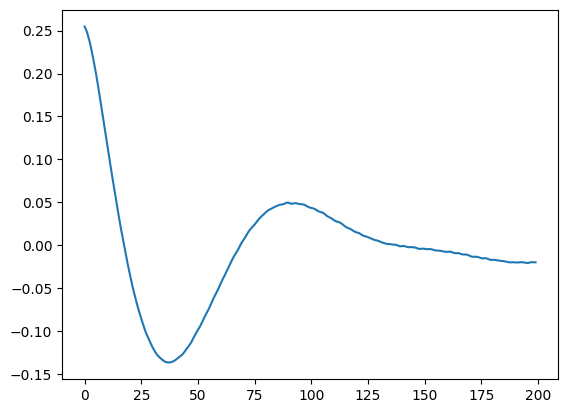

In [32]:
plt.plot(realglitch_reserved[1013].flatten())

### Making the glitch set (one detector + one noise)

In [8]:
noise_first50k = realbkg.reshape(-1,2,200)[:30000]

glitch_L_noise_H = np.concatenate((realglitch_L, noise_first50k[:,[1],:]), axis = 1)
glitch_H_noise_L = np.concatenate((realglitch_H, noise_first50k[:,[0],:]), axis = 1)
realglitch = np.vstack((glitch_L_noise_H, glitch_H_noise_L))
np.random.shuffle(realglitch)
realglitch = realglitch.reshape(-1,200)
realbkg = realbkg[60000:]

del realglitch_L, realglitch_H, glitch_H_noise_L, glitch_L_noise_H

### Making the glitch set (two glitches)

In [79]:
realglitch = np.concatenate((realglitch_L, realglitch_H), axis = 1).reshape(-1,200)

### Normalize the dataset

In [292]:
realbkg = (realbkg - np.transpose([np.mean(realbkg, axis=1)]))/np.transpose([np.std(realbkg, axis=1)]);
realbbh = (realbbh - np.transpose([np.mean(realbbh, axis=1)]))/np.transpose([np.std(realbbh, axis=1)]);
realsg  = (realsg  - np.transpose([np.mean(realsg , axis=1)]))/np.transpose([np.std(realsg, axis=1)]);
realglitch = (realglitch - np.transpose([np.mean(realglitch, axis=1)]))/np.transpose([np.std(realglitch, axis=1)])

KeyboardInterrupt: 

In [80]:
realbkg = realbkg / np.linalg.norm(realbkg, axis = 1).reshape(-1,1)
realbbh = realbbh / np.linalg.norm(realbbh, axis = 1).reshape(-1,1)
realsg  = realsg / np.linalg.norm(realsg, axis = 1).reshape(-1,1)
realglitch = realglitch / np.linalg.norm(realglitch, axis = 1).reshape(-1,1)

### Reserve a certain propotion of set for further study

In [81]:
realbkg_reserved = realbkg[-int(0.2 * len(realbkg))-int(0.2 * len(realbkg))%2:]
realbbh_reserved = realbbh[-int(0.2 * len(realbbh))-int(0.2 * len(realbbh))%2:]
realsg_reserved = realsg[-int(0.2 * len(realsg))-int(0.2 * len(realsg))%2:]
realglitch_reserved = realglitch[-int(0.2 * len(realglitch))-int(0.2 * len(realglitch))%2:]

realbkg = realbkg[:-int(0.2 * len(realbkg))-int(0.2 * len(realbkg))%2]
realbbh = realbbh[:-int(0.2 * len(realbbh))-int(0.2 * len(realbbh))%2]
realsg = realsg[:-int(0.2 * len(realsg))-int(0.2 * len(realsg))%2]
realglitch = realglitch[:-int(0.2 * len(realglitch))-int(0.2 * len(realglitch))%2]

### Final Package

In [82]:
realbkg = realbkg.reshape(-1,2,200)
realbbh = realbbh.reshape(-1,2,200)
realsg = realsg.reshape(-1,2,200)
realglitch = realglitch.reshape(-1,2,200)

In [83]:
realglitch.shape

(24000, 2, 200)

In [84]:
realbkg_reserved = realbkg_reserved.reshape(-1,2,200)
realbbh_reserved = realbbh_reserved.reshape(-1,2,200)
realsg_reserved = realsg_reserved.reshape(-1,2,200)
realglitch_reserved = realglitch_reserved.reshape(-1,2,200)

### If one is only using one detector

In [85]:
realbkg = realbkg[:,[0],:]
realbbh = realbbh[:,[0],:]
realsg = realsg[:,[0],:]
realglitch = realglitch[:,[0],:]

realbkg_reserved = realbkg_reserved[:,[0],:]
realbbh_reserved = realbbh_reserved[:,[0],:]
realsg_reserved = realsg_reserved[:,[0],:]
realglitch_reserved = realglitch_reserved[:,[0],:]

In [86]:
realbkg.shape

(80000, 1, 200)

## GWAK dataset

### Reading the data from file

In [204]:
## If one is using GWAK set

renorm_factor_0 = 20;
renorm_factor_1 = 20;

realbkg = np.load('E://GWNMMAD_data/Tw_dataset/Datasets/background.npz')['data'].reshape(-1,200) / renorm_factor_0;
realbbh = np.load('E://GWNMMAD_data/Tw_dataset/Datasets/bbh_for_challenge.npy').reshape(-1,200) / renorm_factor_0;

realsg = np.load('E://GWNMMAD_data/Tw_dataset/Datasets/sglf_for_challenge.npy').reshape(-1,200) / renorm_factor_0;
# realglitch = np.load("../data/real_glitches_9998_4000Hz_25ms.npz")["strain_time_data"]
realglitch_L = np.load("../Data_cached/real_glitches_snrlt5_60132_4000Hz_25ms.npz")["strain_time_data"][:30000].reshape(-1,1,200) / renorm_factor_1
realglitch_H = np.load('../Data_cached/real_glitches_H_snrlt5_59732_4000Hz_25ms.npz')["strain_time_data"][:30000].reshape(-1,1,200) / renorm_factor_1

### Making the glitch set (one detector + one noise)

In [205]:
noise_first50k = realbkg.reshape(-1,2,200)[:30000]

glitch_L_noise_H = np.concatenate((realglitch_L, noise_first50k[:,[1],:]), axis = 1)
glitch_H_noise_L = np.concatenate((realglitch_H, noise_first50k[:,[0],:]), axis = 1)
realglitch = np.vstack((glitch_L_noise_H, glitch_H_noise_L))
np.random.shuffle(realglitch)
realglitch = realglitch.reshape(-1,200)
realbkg = realbkg[60000:]

del realglitch_L, realglitch_H, glitch_H_noise_L, glitch_L_noise_H

### Normalize the dataset

In [161]:
realbkg = (realbkg - np.transpose([np.mean(realbkg, axis=1)]))/np.transpose([np.std(realbkg, axis=1)]);
realbbh = (realbbh - np.transpose([np.mean(realbbh, axis=1)]))/np.transpose([np.std(realbbh, axis=1)]);
realsg  = (realsg  - np.transpose([np.mean(realsg , axis=1)]))/np.transpose([np.std(realsg, axis=1)]);
realglitch = (realglitch - np.transpose([np.mean(realglitch, axis=1)]))/np.transpose([np.std(realglitch, axis=1)])

In [206]:
realbkg = realbkg / np.linalg.norm(realbkg, axis = 1).reshape(-1,1)
realbbh = realbbh / np.linalg.norm(realbbh, axis = 1).reshape(-1,1)
realsg  = realsg / np.linalg.norm(realsg, axis = 1).reshape(-1,1)
realglitch = realglitch / np.linalg.norm(realglitch, axis = 1).reshape(-1,1)

### Reserve a certain propotion of set for further study

In [207]:
realbkg_reserved = realbkg[-int(0.2 * len(realbkg))-int(0.2 * len(realbkg))%2:]
realbbh_reserved = realbbh[-int(0.2 * len(realbbh))-int(0.2 * len(realbbh))%2:]
realsg_reserved = realsg[-int(0.2 * len(realsg))-int(0.2 * len(realsg))%2:]
realglitch_reserved = realglitch[-int(0.2 * len(realglitch))-int(0.2 * len(realglitch))%2:]

realbkg = realbkg[:-int(0.2 * len(realbkg))-int(0.2 * len(realbkg))%2]
realbbh = realbbh[:-int(0.2 * len(realbbh))-int(0.2 * len(realbbh))%2]
realsg = realsg[:-int(0.2 * len(realsg))-int(0.2 * len(realsg))%2]
realglitch = realglitch[:-int(0.2 * len(realglitch))-int(0.2 * len(realglitch))%2]

### Final Package

In [208]:
realbkg = realbkg.reshape(-1,2,200)
realbbh = realbbh.reshape(-1,2,200)
realsg = realsg.reshape(-1,2,200)
realglitch = realglitch.reshape(-1,2,200)

In [228]:
realbkg.shape

(56000, 2, 200)

In [210]:
realbkg_reserved = realbkg_reserved.reshape(-1,2,200)
realbbh_reserved = realbbh_reserved.reshape(-1,2,200)
realsg_reserved = realsg_reserved.reshape(-1,2,200)
realglitch_reserved = realglitch_reserved.reshape(-1,2,200)

# Training the model

## For supervised learning case

### Trained with noise

In [38]:
version = 'v1'
dInput = 200

In [45]:
n_BKG = len(realbkg)
n_BBH = len(realbbh)
n_SG = len(realsg)
n_GLITCH = len(realglitch)

Epoch: 0094, Training loss=0.000597, Validation loss=0.015089, valid accuracy=30.028818
Time for this epoch: 128.94940900802612


In [41]:
# Beacuse there's already 20% of dataset reserved here, there's no meaning setting the testset. We only do
# training and validation here. 

rTrain = 1-rValidation

n_BKG_train = int(n_BKG * rTrain)
n_BBH_train = int(n_BBH * rTrain)
n_SG_train = int(n_SG * rTrain)
n_GLITCH_train = int(n_GLITCH * rTrain)

n_BKG_validation = int(n_BKG * rValidation)
n_BBH_validation = int(n_BBH * rValidation)
n_SG_validation = int(n_SG * rValidation)
n_GLITCH_validation = int(n_GLITCH * rValidation)


X_train = np.concatenate((realglitch[:n_GLITCH_train], 
                          realbbh[:n_BBH_train], 
                          realsg[:n_SG_train], 
                          realbkg[:n_BKG_train]), axis = 0)
target_train = np.concatenate((np.ones(n_GLITCH_train + n_BBH_train + n_SG_train), np.zeros(n_BKG_train)))

X_validation = np.concatenate((realglitch[-n_GLITCH_validation:], 
                          realbbh[-n_BBH_validation:], 
                          realsg[-n_SG_validation:], 
                          realbkg[-n_BKG_validation:]), axis = 0)
target_validation = np.concatenate((np.ones(n_GLITCH_validation + n_BBH_validation + n_SG_validation), np.zeros(n_BKG_validation)))


train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(target_train.reshape((len(target_train), 1))))
# test_dataset  = TensorDataset(torch.FloatTensor(X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))),  torch.FloatTensor(target_test.reshape((len(target_test), 1))))
valid_dataset = TensorDataset(torch.FloatTensor(X_validation), torch.FloatTensor(target_validation.reshape((len(target_validation), 1))))

trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
validationDataLoader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=True)

In [42]:
X_train.shape

(744233, 2, 200)

In [45]:
classifier = WaveletCNNSL(num_ifos=2, c_depth=5, n_chann=8, l1=64, l2=16).cuda()
print(sum(p.numel() for p in classifier.parameters() if p.requires_grad))

optimizer = optim.Adam(classifier.parameters(), lr=0.00005)
loss_func = nn.BCEWithLogitsLoss(pos_weight=torch.FloatTensor([n_GLITCH_train/(n_BKG_train + n_BBH_train + n_SG_train)])).cuda()
loss_train = np.empty((epochs, ))
loss_validation = np.empty((epochs, ))

for epoch in range(epochs):

    t0 = time.time()
    classifier.train()
    for batchidx, (x, tgt_index) in enumerate(trainDataLoader):
        x = x.cuda()
        tgt_index = tgt_index.cuda()
        output = classifier(x)
        loss = loss_func(output, tgt_index)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    classifier.eval()
    with torch.no_grad():
        val_loss = 0
        n_correct = 0;
        for batchidx, (x, tgt_index) in enumerate(validationDataLoader):
            x = x.cuda()
            tgt_index = tgt_index.cuda()
            output = classifier(x)
            lossVal = loss_func(output, tgt_index)
            val_loss += lossVal.item()
            n_correct += torch.eq(tgt_index, torch.argmax(output, dim=1)).sum().item()

        val_loss /= len(validationDataLoader)

    loss_train[epoch] = loss.item()
    loss_validation[epoch] = val_loss
    print('Epoch: %04d, Training loss=%f, Validation loss=%f, valid accuracy=%f' % (epoch+1, loss_train[epoch], val_loss, n_correct*1./len(X_validation)))
    print('Time for this epoch: ' + str(time.time() - t0))

#     print(time.time() - t0)

plt.plot(loss_train)
plt.plot(loss_validation)

torch.save(classifier.cuda(), "../Model_cached/Wavelet_model_SL_noisetrained"+version+".pt")
# np.savetxt("../data/SupLearn/lossClassifierTraining_64-64-16.dat", [loss_train, loss_validation])

13170
Epoch: 0001, Training loss=0.003075, Validation loss=0.015904, valid accuracy=30.028818
Time for this epoch: 129.90688848495483
Epoch: 0002, Training loss=0.046359, Validation loss=0.015486, valid accuracy=30.028818
Time for this epoch: 129.0955696105957
Epoch: 0003, Training loss=0.003210, Validation loss=0.015535, valid accuracy=30.029169
Time for this epoch: 131.192809343338
Epoch: 0004, Training loss=0.001686, Validation loss=0.015377, valid accuracy=30.029169
Time for this epoch: 129.25594282150269
Epoch: 0005, Training loss=0.001491, Validation loss=0.015311, valid accuracy=30.028818
Time for this epoch: 128.64245557785034
Epoch: 0006, Training loss=0.000947, Validation loss=0.015329, valid accuracy=30.029169
Time for this epoch: 128.9802668094635
Epoch: 0007, Training loss=0.051127, Validation loss=0.015243, valid accuracy=30.029169
Time for this epoch: 128.92957282066345
Epoch: 0008, Training loss=0.002679, Validation loss=0.015149, valid accuracy=30.028818
Time for this 

### Trained with glitch

In [331]:
version = 'v2'
dInput = 200

In [332]:
n_BKG = len(realbkg)
n_BBH = len(realbbh)
n_SG = len(realsg)
n_GLITCH = len(realglitch)

In [333]:
# Beacuse there's already 20% of dataset reserved here, there's no meaning setting the testset. We only do
# training and validation here. 

rTrain = 1-rValidation

n_BKG_train = int(n_BKG * rTrain)
n_BBH_train = int(n_BBH * rTrain)
n_SG_train = int(n_SG * rTrain)
n_GLITCH_train = int(n_GLITCH * rTrain)

n_BKG_validation = int(n_BKG * rValidation)
n_BBH_validation = int(n_BBH * rValidation)
n_SG_validation = int(n_SG * rValidation)
n_GLITCH_validation = int(n_GLITCH * rValidation)


X_train = np.concatenate((realbkg[:n_BKG_train], 
                          realbbh[:n_BBH_train], 
                          realsg[:n_SG_train], 
                          realglitch[:n_GLITCH_train]), axis = 0)
target_train = np.concatenate((np.ones(n_BKG_train + n_BBH_train + n_SG_train), np.zeros(n_GLITCH_train)))

X_validation = np.concatenate((realbkg[:n_BKG_validation], 
                          realbbh[:n_BBH_validation], 
                          realsg[:n_SG_validation], 
                          realglitch[:n_GLITCH_validation]), axis = 0)
target_validation = np.concatenate((np.ones(n_BKG_validation + n_BBH_validation + n_SG_validation), np.zeros(n_GLITCH_validation)))


train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(target_train.reshape((len(target_train), 1))))
# test_dataset  = TensorDataset(torch.FloatTensor(X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))),  torch.FloatTensor(target_test.reshape((len(target_test), 1))))
valid_dataset = TensorDataset(torch.FloatTensor(X_validation), torch.FloatTensor(target_validation.reshape((len(target_validation), 1))))

trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
validationDataLoader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=True)

In [334]:
X_train.shape

(744233, 1, 200)

In [339]:
1

1

In [335]:
classifier = WaveletCNNSL(num_ifos=1, c_depth=5, n_chann=8, l1=20, l2=10).cuda()
print(sum(p.numel() for p in classifier.parameters() if p.requires_grad))

optimizer = optim.Adam(classifier.parameters(), lr=0.00005)
loss_func = nn.BCEWithLogitsLoss(pos_weight=torch.FloatTensor([n_GLITCH_train/(n_BKG_train + n_BBH_train + n_SG_train)])).cuda()
loss_train = np.empty((epochs, ))
loss_validation = np.empty((epochs, ))

for epoch in range(epochs):

    t0 = time.time()
    classifier.train()
    for batchidx, (x, tgt_index) in enumerate(trainDataLoader):
        x = x.cuda()
        tgt_index = tgt_index.cuda()
        output = classifier(x)
        loss = loss_func(output, tgt_index)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    classifier.eval()
    with torch.no_grad():
        val_loss = 0
        n_correct = 0;
        for batchidx, (x, tgt_index) in enumerate(validationDataLoader):
            x = x.cuda()
            tgt_index = tgt_index.cuda()
            output = classifier(x)
            lossVal = loss_func(output, tgt_index)
            val_loss += lossVal.item()
            n_correct += torch.eq(tgt_index, torch.argmax(output, dim=1)).sum().item()

        val_loss /= len(validationDataLoader)

    loss_train[epoch] = loss.item()
    loss_validation[epoch] = val_loss
    print('Epoch: %04d, Training loss=%f, Validation loss=%f, valid accuracy=%f' % (epoch+1, loss_train[epoch], val_loss, n_correct*1./len(X_validation)))
    print('Time for this epoch: ' + str(time.time() - t0))

#     print(time.time() - t0)

plt.plot(loss_train)
plt.plot(loss_validation)

torch.save(classifier.cuda(), "../Model_cached/Wavelet_model_SL"+version+".pt")
# np.savetxt("../data/SupLearn/lossClassifierTraining_64-64-16.dat", [loss_train, loss_validation])

4744
Epoch: 0001, Training loss=0.019663, Validation loss=0.034232, valid accuracy=0.928759
Time for this epoch: 134.39846467971802
Epoch: 0002, Training loss=0.116145, Validation loss=0.031601, valid accuracy=0.928759
Time for this epoch: 132.00943803787231
Epoch: 0003, Training loss=0.056610, Validation loss=0.029212, valid accuracy=0.928759
Time for this epoch: 133.54403138160706
Epoch: 0004, Training loss=0.017340, Validation loss=0.027928, valid accuracy=0.928759
Time for this epoch: 131.58030486106873
Epoch: 0005, Training loss=0.015914, Validation loss=0.027117, valid accuracy=0.928759
Time for this epoch: 133.86880540847778
Epoch: 0006, Training loss=0.015337, Validation loss=0.026677, valid accuracy=0.928759
Time for this epoch: 131.43181777000427
Epoch: 0007, Training loss=0.077412, Validation loss=0.026082, valid accuracy=0.928759
Time for this epoch: 132.1332230567932


In [ ]:
classifier = WaveletCNNSL(num_ifos=2, c_depth=5, n_chann=8, l1=64, l2=16).cuda()
print(sum(p.numel() for p in classifier.parameters() if p.requires_grad))

optimizer = optim.Adam(classifier.parameters(), lr=0.00005)
loss_func = nn.BCEWithLogitsLoss(pos_weight=torch.FloatTensor([n_GLITCH_train/(n_BKG_train + n_BBH_train + n_SG_train)])).cuda()
loss_train = np.empty((epochs, ))
loss_validation = np.empty((epochs, ))

for epoch in range(epochs):

    t0 = time.time()
    classifier.train()
    for batchidx, (x, tgt_index) in enumerate(trainDataLoader):
        x = x.cuda()
        tgt_index = tgt_index.cuda()
        output = classifier(x)
        loss = loss_func(output, tgt_index)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    classifier.eval()
    with torch.no_grad():
        val_loss = 0
        n_correct = 0;
        for batchidx, (x, tgt_index) in enumerate(validationDataLoader):
            x = x.cuda()
            tgt_index = tgt_index.cuda()
            output = classifier(x)
            lossVal = loss_func(output, tgt_index)
            val_loss += lossVal.item()
            n_correct += torch.eq(tgt_index, torch.argmax(output, dim=1)).sum().item()

        val_loss /= len(validationDataLoader)

    loss_train[epoch] = loss.item()
    loss_validation[epoch] = val_loss
    print('Epoch: %04d, Training loss=%f, Validation loss=%f, valid accuracy=%f' % (epoch+1, loss_train[epoch], val_loss, n_correct*1./len(X_validation)))
    print('Time for this epoch: ' + str(time.time() - t0))

#     print(time.time() - t0)

plt.plot(loss_train)
plt.plot(loss_validation)

torch.save(classifier.cuda(), "../Model_cached/Wavelet_model_SL"+version+".pt")
# np.savetxt("../data/SupLearn/lossClassifierTraining_64-64-16.dat", [loss_train, loss_validation])

NameError: name 'WaveletCNNSL' is not defined

### Trained with noise

## For unsupervised learning case

### Trained with glitch

In [51]:
version = 'v17'
dInput = 200

In [47]:
n_BKG = len(realbkg)
n_BBH = len(realbbh)
n_SG = len(realsg)
n_GLITCH = len(realglitch)

In [48]:
# Beacuse there's already 20% of dataset reserved here, there's no meaning setting the testset. We only do
# training and validation here. 

rTrain = 1-rValidation

n_BKG_train = int(n_BKG * rTrain)
n_BBH_train = int(n_BBH * rTrain)
n_SG_train = int(n_SG * rTrain)
n_GLITCH_train = int(n_GLITCH * rTrain)

n_BKG_validation = int(n_BKG * rValidation)
n_BBH_validation = int(n_BBH * rValidation)
n_SG_validation = int(n_SG * rValidation)
n_GLITCH_validation = int(n_GLITCH * rValidation)

In [ ]:
# Beacuse there's already 20% of dataset reserved here, there's no meaning setting the testset. We only do
# training and validation here. 

rTrain = 1-rValidation

n_BKG_train = int(n_BKG * rTrain)
n_BBH_train = int(n_BBH * rTrain)
n_SG_train = int(n_SG * rTrain)
n_GLITCH_train = int(n_GLITCH * rTrain)

n_BKG_validation = int(n_BKG * rValidation)
n_BBH_validation = int(n_BBH * rValidation)
n_SG_validation = int(n_SG * rValidation)
n_GLITCH_validation = int(n_GLITCH * rValidation)


X_train = np.concatenate((realbkg[:n_BKG_train], 
                          realbbh[:n_BBH_train], 
                          realsg[:n_SG_train], 
                          realglitch[:n_GLITCH_train]), axis = 0)
target_train = np.concatenate((np.ones(n_BKG_train + n_BBH_train + n_SG_train), np.zeros(n_GLITCH_train)))

X_validation = np.concatenate((realbkg[-n_BKG_validation:], 
                          realbbh[-n_BBH_validation:], 
                          realsg[-n_SG_validation:], 
                          realglitch[-n_GLITCH_validation:]), axis = 0)
target_validation = np.concatenate((np.ones(n_BKG_validation + n_BBH_validation + n_SG_validation), np.zeros(n_GLITCH_validation)))


train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(target_train.reshape((len(target_train), 1))))
# test_dataset  = TensorDataset(torch.FloatTensor(X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))),  torch.FloatTensor(target_test.reshape((len(target_test), 1))))
valid_dataset = TensorDataset(torch.FloatTensor(X_validation), torch.FloatTensor(target_validation.reshape((len(target_validation), 1))))

trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
validationDataLoader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=True)

MemoryError: Unable to allocate 2.22 GiB for an array with shape (744233, 2, 200) and data type float64

In [49]:
X_train = realglitch[:n_GLITCH_train]
X_validation = realglitch[-n_GLITCH_validation:]

train_dataset = TensorDataset(torch.FloatTensor(X_train))
# test_dataset  = TensorDataset(torch.FloatTensor(X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))),  torch.FloatTensor(target_test.reshape((len(target_test), 1))))
valid_dataset = TensorDataset(torch.FloatTensor(X_validation))

trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
validationDataLoader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=True)

In [50]:
X_train.shape

(36000, 1, 200)

513
Epoch: 0001, Training loss=0.021786, Validation loss=0.021139, valid accuracy=0.000000
Time for this epoch: 6.741598844528198
Epoch: 0002, Training loss=0.015442, Validation loss=0.015010, valid accuracy=0.000000
Time for this epoch: 6.18233847618103
Epoch: 0003, Training loss=0.005803, Validation loss=0.005625, valid accuracy=0.000000
Time for this epoch: 6.248799800872803
Epoch: 0004, Training loss=0.005076, Validation loss=0.005066, valid accuracy=0.000000
Time for this epoch: 6.153264760971069
Epoch: 0005, Training loss=0.005013, Validation loss=0.005025, valid accuracy=0.000000
Time for this epoch: 6.306370973587036
Epoch: 0006, Training loss=0.005018, Validation loss=0.005012, valid accuracy=0.000000
Time for this epoch: 6.243082046508789
Epoch: 0007, Training loss=0.005016, Validation loss=0.005007, valid accuracy=0.000000
Time for this epoch: 6.087221384048462
Epoch: 0008, Training loss=0.004997, Validation loss=0.005004, valid accuracy=0.000000
Time for this epoch: 6.08294

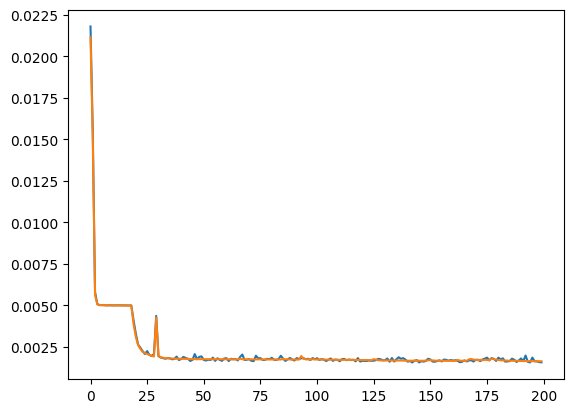

In [319]:
classifier = WaveletCNNAEND(num_ifos=1, c_depth=6, n_chann=4, l1=20, l2=10).cuda()
print(sum(p.numel() for p in classifier.parameters() if p.requires_grad))

optimizer = optim.Adam(classifier.parameters(), lr=0.0005)
loss_func = nn.MSELoss().cuda()
loss_train = np.empty((epochs, ))
loss_validation = np.empty((epochs, ))

for epoch in range(epochs):

    t0 = time.time()
    classifier.train()
    for batchidx, x in enumerate(trainDataLoader):
        x = x[0].cuda()
        # print(x.shape)
        # tgt_index = tgt_index.cuda()
        output = classifier(x)
        loss = loss_func(output, x)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    classifier.eval()
    with torch.no_grad():
        val_loss = 0
        n_correct = 0;
        for batchidx, x in enumerate(validationDataLoader):
            x = x[0].cuda()
            # tgt_index = tgt_index.cuda()
            output = classifier(x)
            lossVal = loss_func(output, x)
            val_loss += lossVal.item()
            # n_correct += torch.eq(tgt_index, torch.argmax(output, dim=1)).sum().item()

        val_loss /= len(validationDataLoader)

    loss_train[epoch] = loss.item()
    loss_validation[epoch] = val_loss
    print('Epoch: %04d, Training loss=%f, Validation loss=%f, valid accuracy=%f' % (epoch+1, loss_train[epoch], val_loss, n_correct*1./len(X_validation)))
    print('Time for this epoch: ' + str(time.time() - t0))

#     print(time.time() - t0)

plt.plot(loss_train)
plt.plot(loss_validation)

torch.save(classifier.cuda(), "../Model_cached/Wavelet_model_glitchtrained_AE"+version+".pt")
# np.savetxt("../data/SupLearn/lossClassifierTraining_64-64-16.dat", [loss_train, loss_validation])

8225
Epoch: 0001, Training loss=0.027730, Validation loss=0.027406, valid accuracy=0.000000
Time for this epoch: 15.635116338729858
Epoch: 0002, Training loss=0.005028, Validation loss=0.005080, valid accuracy=0.000000
Time for this epoch: 9.902024984359741
Epoch: 0003, Training loss=0.005018, Validation loss=0.005017, valid accuracy=0.000000
Time for this epoch: 10.074849367141724
Epoch: 0004, Training loss=0.004999, Validation loss=0.005005, valid accuracy=0.000000
Time for this epoch: 10.069425582885742
Epoch: 0005, Training loss=0.005000, Validation loss=0.005002, valid accuracy=0.000000
Time for this epoch: 10.142536878585815
Epoch: 0006, Training loss=0.005001, Validation loss=0.005001, valid accuracy=0.000000
Time for this epoch: 9.852554559707642
Epoch: 0007, Training loss=0.005000, Validation loss=0.005000, valid accuracy=0.000000
Time for this epoch: 10.053455352783203
Epoch: 0008, Training loss=0.005000, Validation loss=0.005000, valid accuracy=0.000000
Time for this epoch: 

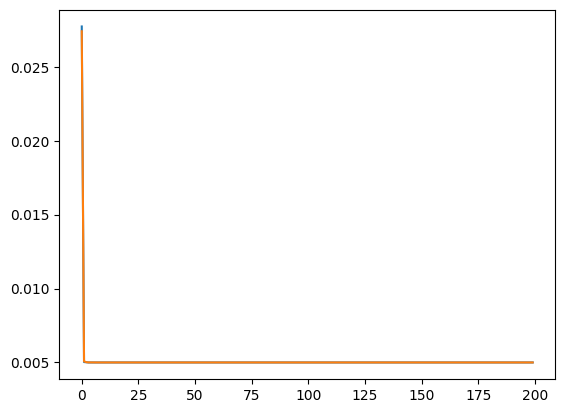

In [87]:
version = 'v17'

classifier = WaveletCNNAE(num_ifos=1, c_depth=5, n_chann=4, l1=20, l2=10).cuda()
print(sum(p.numel() for p in classifier.parameters() if p.requires_grad))

optimizer = optim.Adam(classifier.parameters(), lr=0.0005)
loss_func = nn.MSELoss().cuda()
loss_train = np.empty((epochs, ))
loss_validation = np.empty((epochs, ))

for epoch in range(epochs):

    t0 = time.time()
    classifier.train()
    for batchidx, x in enumerate(trainDataLoader):
        x = x[0].cuda()
        # print(x.shape)
        # tgt_index = tgt_index.cuda()
        output = classifier(x)
        loss = loss_func(output, x)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    classifier.eval()
    with torch.no_grad():
        val_loss = 0
        n_correct = 0;
        for batchidx, x in enumerate(validationDataLoader):
            x = x[0].cuda()
            # tgt_index = tgt_index.cuda()
            output = classifier(x)
            lossVal = loss_func(output, x)
            val_loss += lossVal.item()
            # n_correct += torch.eq(tgt_index, torch.argmax(output, dim=1)).sum().item()

        val_loss /= len(validationDataLoader)

    loss_train[epoch] = loss.item()
    loss_validation[epoch] = val_loss
    print('Epoch: %04d, Training loss=%f, Validation loss=%f, valid accuracy=%f' % (epoch+1, loss_train[epoch], val_loss, n_correct*1./len(X_validation)))
    print('Time for this epoch: ' + str(time.time() - t0))

#     print(time.time() - t0)

plt.plot(loss_train)
plt.plot(loss_validation)

torch.save(classifier.cuda(), "../Model_cached/Wavelet_model_glitchtrained_AE"+version+"_20_10_permutated.pt")
# np.savetxt("../data/SupLearn/lossClassifierTraining_64-64-16.dat", [loss_train, loss_validation])

524
Epoch: 0001, Training loss=0.008375, Validation loss=0.008354, valid accuracy=0.000000
Time for this epoch: 11.290385484695435
Epoch: 0002, Training loss=0.005079, Validation loss=0.005032, valid accuracy=0.000000
Time for this epoch: 10.738962411880493
Epoch: 0003, Training loss=0.005007, Validation loss=0.005005, valid accuracy=0.000000
Time for this epoch: 10.74092960357666
Epoch: 0004, Training loss=0.005015, Validation loss=0.005008, valid accuracy=0.000000
Time for this epoch: 10.758487939834595
Epoch: 0005, Training loss=0.004991, Validation loss=0.004997, valid accuracy=0.000000
Time for this epoch: 10.689968347549438
Epoch: 0006, Training loss=0.004984, Validation loss=0.004993, valid accuracy=0.000000
Time for this epoch: 10.79765272140503
Epoch: 0007, Training loss=0.004984, Validation loss=0.004987, valid accuracy=0.000000
Time for this epoch: 10.992913961410522
Epoch: 0008, Training loss=0.004977, Validation loss=0.004979, valid accuracy=0.000000
Time for this epoch: 1

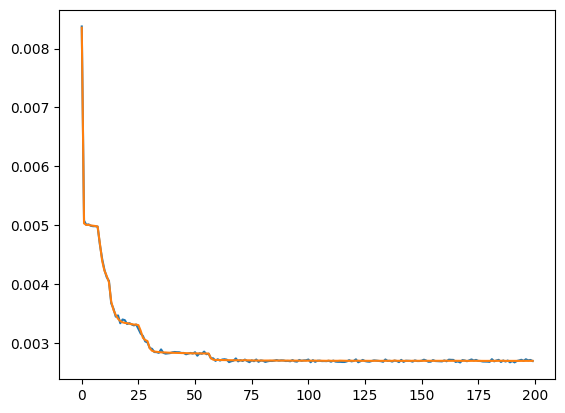

In [174]:
classifier = WaveletCNNAEND(num_ifos=2, c_depth=6, n_chann=4, l1=32, l2=8).cuda()
print(sum(p.numel() for p in classifier.parameters() if p.requires_grad))

optimizer = optim.Adam(classifier.parameters(), lr=0.0005)
loss_func = nn.MSELoss().cuda()
loss_train = np.empty((epochs, ))
loss_validation = np.empty((epochs, ))

for epoch in range(epochs):

    t0 = time.time()
    classifier.train()
    for batchidx, x in enumerate(trainDataLoader):
        x = x[0].cuda()
        # print(x.shape)
        # tgt_index = tgt_index.cuda()
        output = classifier(x)
        loss = loss_func(output, x)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    classifier.eval()
    with torch.no_grad():
        val_loss = 0
        n_correct = 0;
        for batchidx, x in enumerate(validationDataLoader):
            x = x[0].cuda()
            # tgt_index = tgt_index.cuda()
            output = classifier(x)
            lossVal = loss_func(output, x)
            val_loss += lossVal.item()
            # n_correct += torch.eq(tgt_index, torch.argmax(output, dim=1)).sum().item()

        val_loss /= len(validationDataLoader)

    loss_train[epoch] = loss.item()
    loss_validation[epoch] = val_loss
    print('Epoch: %04d, Training loss=%f, Validation loss=%f, valid accuracy=%f' % (epoch+1, loss_train[epoch], val_loss, n_correct*1./len(X_validation)))
    print('Time for this epoch: ' + str(time.time() - t0))

#     print(time.time() - t0)

plt.plot(loss_train)
plt.plot(loss_validation)

torch.save(classifier.cuda(), "../Model_cached/Wavelet_model_glitchtrained_AE"+version+".pt")
# np.savetxt("../data/SupLearn/lossClassifierTraining_64-64-16.dat", [loss_train, loss_validation])

10398
Epoch: 0001, Training loss=0.009543, Validation loss=0.009463, valid accuracy=0.000000
Time for this epoch: 13.589632034301758
Epoch: 0002, Training loss=0.005142, Validation loss=0.005174, valid accuracy=0.000000
Time for this epoch: 12.817597389221191
Epoch: 0003, Training loss=0.005033, Validation loss=0.005031, valid accuracy=0.000000
Time for this epoch: 12.832215309143066
Epoch: 0004, Training loss=0.005006, Validation loss=0.005013, valid accuracy=0.000000
Time for this epoch: 12.949487686157227
Epoch: 0005, Training loss=0.005009, Validation loss=0.005007, valid accuracy=0.000000
Time for this epoch: 12.817851305007935
Epoch: 0006, Training loss=0.005003, Validation loss=0.005003, valid accuracy=0.000000
Time for this epoch: 13.139099359512329
Epoch: 0007, Training loss=0.005003, Validation loss=0.005002, valid accuracy=0.000000
Time for this epoch: 12.782812118530273
Epoch: 0008, Training loss=0.005001, Validation loss=0.005001, valid accuracy=0.000000
Time for this epoc

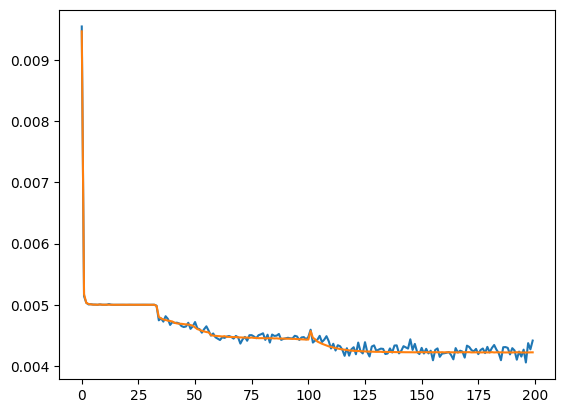

In [216]:
version = 'v13'

classifier = WaveletCNNAE(num_ifos=2, c_depth=6, n_chann=4, l1=32, l2=8).cuda()
print(sum(p.numel() for p in classifier.parameters() if p.requires_grad))

optimizer = optim.Adam(classifier.parameters(), lr=0.0005)
loss_func = nn.MSELoss().cuda()
loss_train = np.empty((epochs, ))
loss_validation = np.empty((epochs, ))

for epoch in range(epochs):

    t0 = time.time()
    classifier.train()
    for batchidx, x in enumerate(trainDataLoader):
        x = x[0].cuda()
        # print(x.shape)
        # tgt_index = tgt_index.cuda()
        output = classifier(x)
        loss = loss_func(output, x)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    classifier.eval()
    with torch.no_grad():
        val_loss = 0
        n_correct = 0;
        for batchidx, x in enumerate(validationDataLoader):
            x = x[0].cuda()
            # tgt_index = tgt_index.cuda()
            output = classifier(x)
            lossVal = loss_func(output, x)
            val_loss += lossVal.item()
            # n_correct += torch.eq(tgt_index, torch.argmax(output, dim=1)).sum().item()

        val_loss /= len(validationDataLoader)

    loss_train[epoch] = loss.item()
    loss_validation[epoch] = val_loss
    print('Epoch: %04d, Training loss=%f, Validation loss=%f, valid accuracy=%f' % (epoch+1, loss_train[epoch], val_loss, n_correct*1./len(X_validation)))
    print('Time for this epoch: ' + str(time.time() - t0))

#     print(time.time() - t0)

plt.plot(loss_train)
plt.plot(loss_validation)

torch.save(classifier.cuda(), "../Model_cached/Wavelet_model_glitchtrained_AE"+version+"_32_8_GWAK.pt")
# np.savetxt("../data/SupLearn/lossClassifierTraining_64-64-16.dat", [loss_train, loss_validation])

10431
Epoch: 0001, Training loss=0.005093, Validation loss=0.005083, valid accuracy=0.000000
Time for this epoch: 13.10512900352478
Epoch: 0002, Training loss=0.005004, Validation loss=0.005007, valid accuracy=0.000000
Time for this epoch: 13.178333282470703
Epoch: 0003, Training loss=0.005001, Validation loss=0.005002, valid accuracy=0.000000
Time for this epoch: 13.415843486785889
Epoch: 0004, Training loss=0.005003, Validation loss=0.005001, valid accuracy=0.000000
Time for this epoch: 13.134289503097534
Epoch: 0005, Training loss=0.005000, Validation loss=0.005000, valid accuracy=0.000000
Time for this epoch: 13.22403597831726
Epoch: 0006, Training loss=0.005000, Validation loss=0.005000, valid accuracy=0.000000
Time for this epoch: 13.184117794036865
Epoch: 0007, Training loss=0.005000, Validation loss=0.005000, valid accuracy=0.000000
Time for this epoch: 13.183037281036377
Epoch: 0008, Training loss=0.005000, Validation loss=0.005000, valid accuracy=0.000000
Time for this epoch:

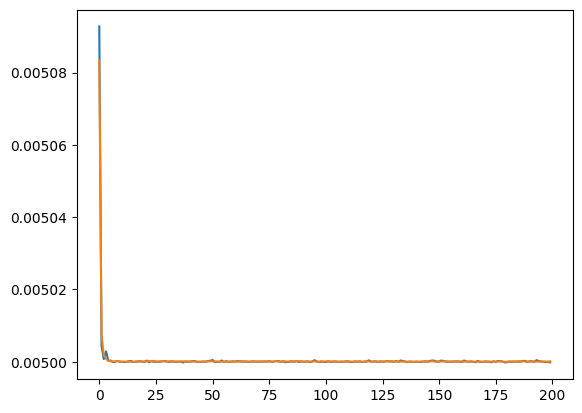

In [150]:
version = 'v11'

classifier = WaveletCNNAEMC(num_ifos=2, c_depth=6, n_chann=4, l1=32, l2=8).cuda()
print(sum(p.numel() for p in classifier.parameters() if p.requires_grad))

optimizer = optim.Adam(classifier.parameters(), lr=0.0005)
loss_func = nn.MSELoss().cuda()
loss_train = np.empty((epochs, ))
loss_validation = np.empty((epochs, ))

for epoch in range(epochs):

    t0 = time.time()
    classifier.train()
    for batchidx, x in enumerate(trainDataLoader):
        x = x[0].cuda()
        # print(x.shape)
        # tgt_index = tgt_index.cuda()
        output = classifier(x)
        loss = loss_func(output, x)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    classifier.eval()
    with torch.no_grad():
        val_loss = 0
        n_correct = 0;
        for batchidx, x in enumerate(validationDataLoader):
            x = x[0].cuda()
            # tgt_index = tgt_index.cuda()
            output = classifier(x)
            lossVal = loss_func(output, x)
            val_loss += lossVal.item()
            # n_correct += torch.eq(tgt_index, torch.argmax(output, dim=1)).sum().item()

        val_loss /= len(validationDataLoader)

    loss_train[epoch] = loss.item()
    loss_validation[epoch] = val_loss
    print('Epoch: %04d, Training loss=%f, Validation loss=%f, valid accuracy=%f' % (epoch+1, loss_train[epoch], val_loss, n_correct*1./len(X_validation)))
    print('Time for this epoch: ' + str(time.time() - t0))

#     print(time.time() - t0)

plt.plot(loss_train)
plt.plot(loss_validation)

torch.save(classifier.cuda(), "../Model_cached/Wavelet_model_glitchtrained_AE"+version+"_32_8.pt")
# np.savetxt("../data/SupLearn/lossClassifierTraining_64-64-16.dat", [loss_train, loss_validation])

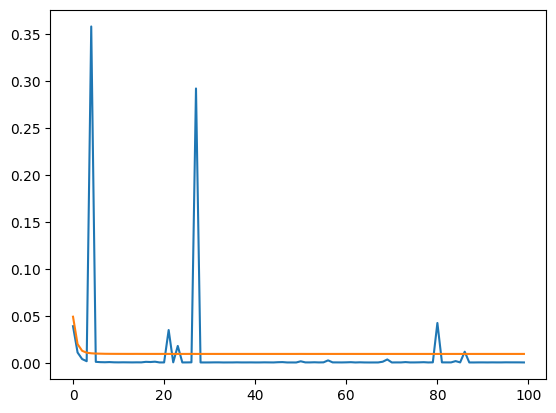

In [79]:
plt.plot(loss_train)
plt.plot(loss_validation)

### Trained with noise

In [229]:
version = 'v3'
dInput = 200

In [230]:
n_BKG = len(realbkg)
n_BBH = len(realbbh)
n_SG = len(realsg)
n_GLITCH = len(realglitch)

In [231]:
# Beacuse there's already 20% of dataset reserved here, there's no meaning setting the testset. We only do
# training and validation here. 

rTrain = 1-rValidation

n_BKG_train = int(n_BKG * rTrain)
n_BBH_train = int(n_BBH * rTrain)
n_SG_train = int(n_SG * rTrain)
n_GLITCH_train = int(n_GLITCH * rTrain)

n_BKG_validation = int(n_BKG * rValidation)
n_BBH_validation = int(n_BBH * rValidation)
n_SG_validation = int(n_SG * rValidation)
n_GLITCH_validation = int(n_GLITCH * rValidation)

In [37]:
# Beacuse there's already 20% of dataset reserved here, there's no meaning setting the testset. We only do
# training and validation here. 

rTrain = 1-rValidation

n_BKG_train = int(n_BKG * rTrain)
n_BBH_train = int(n_BBH * rTrain)
n_SG_train = int(n_SG * rTrain)
n_GLITCH_train = int(n_GLITCH * rTrain)

n_BKG_validation = int(n_BKG * rValidation)
n_BBH_validation = int(n_BBH * rValidation)
n_SG_validation = int(n_SG * rValidation)
n_GLITCH_validation = int(n_GLITCH * rValidation)


X_train = np.concatenate((realbkg[:n_BKG_train], 
                          realbbh[:n_BBH_train], 
                          realsg[:n_SG_train], 
                          realglitch[:n_GLITCH_train]), axis = 0)
target_train = np.concatenate((np.ones(n_BKG_train + n_BBH_train + n_SG_train), np.zeros(n_GLITCH_train)))

X_validation = np.concatenate((realbkg[-n_BKG_validation:], 
                          realbbh[-n_BBH_validation:], 
                          realsg[-n_SG_validation:], 
                          realglitch[-n_GLITCH_validation:]), axis = 0)
target_validation = np.concatenate((np.ones(n_BKG_validation + n_BBH_validation + n_SG_validation), np.zeros(n_GLITCH_validation)))


train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(target_train.reshape((len(target_train), 1))))
# test_dataset  = TensorDataset(torch.FloatTensor(X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))),  torch.FloatTensor(target_test.reshape((len(target_test), 1))))
valid_dataset = TensorDataset(torch.FloatTensor(X_validation), torch.FloatTensor(target_validation.reshape((len(target_validation), 1))))

trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
validationDataLoader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=True)

MemoryError: Unable to allocate 2.22 GiB for an array with shape (744233, 2, 200) and data type float64

In [232]:
X_train = realbkg[:n_BKG_train]
X_validation = realbkg[-n_BKG_validation:]

train_dataset = TensorDataset(torch.FloatTensor(X_train))
# test_dataset  = TensorDataset(torch.FloatTensor(X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))),  torch.FloatTensor(target_test.reshape((len(target_test), 1))))
valid_dataset = TensorDataset(torch.FloatTensor(X_validation))

trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
validationDataLoader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=True)

In [233]:
X_train.shape

(50400, 2, 200)

13006
Epoch: 0001, Training loss=0.235774, Validation loss=0.232562, valid accuracy=0.000000
Time for this epoch: 13.416648387908936
Epoch: 0002, Training loss=0.086742, Validation loss=0.088408, valid accuracy=0.000000
Time for this epoch: 13.252073049545288
Epoch: 0003, Training loss=0.029163, Validation loss=0.028331, valid accuracy=0.000000
Time for this epoch: 13.225891590118408
Epoch: 0004, Training loss=0.015610, Validation loss=0.015176, valid accuracy=0.000000
Time for this epoch: 13.1875581741333
Epoch: 0005, Training loss=0.011418, Validation loss=0.011483, valid accuracy=0.000000
Time for this epoch: 13.444427490234375
Epoch: 0006, Training loss=0.008631, Validation loss=0.008427, valid accuracy=0.000000
Time for this epoch: 13.319969415664673
Epoch: 0007, Training loss=0.008362, Validation loss=0.008133, valid accuracy=0.000000
Time for this epoch: 13.227837800979614
Epoch: 0008, Training loss=0.007955, Validation loss=0.007896, valid accuracy=0.000000
Time for this epoch:

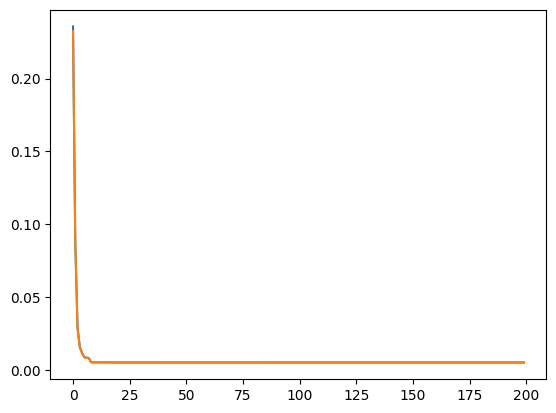

In [235]:
classifier = WaveletCNNAE(num_ifos=2, c_depth=5, n_chann=4, l1=32, l2=16).cuda()
print(sum(p.numel() for p in classifier.parameters() if p.requires_grad))

optimizer = optim.Adam(classifier.parameters(), lr=0.00005)
loss_func = nn.MSELoss().cuda()
loss_train = np.empty((epochs, ))
loss_validation = np.empty((epochs, ))

for epoch in range(epochs):

    t0 = time.time()
    classifier.train()
    for batchidx, x in enumerate(trainDataLoader):
        x = x[0].cuda()
        # print(x.shape)
        # tgt_index = tgt_index.cuda()
        output = classifier(x)
        loss = loss_func(output, x)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    classifier.eval()
    with torch.no_grad():
        val_loss = 0
        n_correct = 0;
        for batchidx, x in enumerate(validationDataLoader):
            x = x[0].cuda()
            # tgt_index = tgt_index.cuda()
            output = classifier(x)
            lossVal = loss_func(output, x)
            val_loss += lossVal.item()
            # n_correct += torch.eq(tgt_index, torch.argmax(output, dim=1)).sum().item()

        val_loss /= len(validationDataLoader)

    loss_train[epoch] = loss.item()
    loss_validation[epoch] = val_loss
    print('Epoch: %04d, Training loss=%f, Validation loss=%f, valid accuracy=%f' % (epoch+1, loss_train[epoch], val_loss, n_correct*1./len(X_validation)))
    print('Time for this epoch: ' + str(time.time() - t0))

#     print(time.time() - t0)

plt.plot(loss_train)
plt.plot(loss_validation)

torch.save(classifier.cuda(), "../Model_cached/Wavelet_model_AE"+version+"_GWAK_trained.pt")
# np.savetxt("../data/SupLearn/lossClassifierTraining_64-64-16.dat", [loss_train, loss_validation])

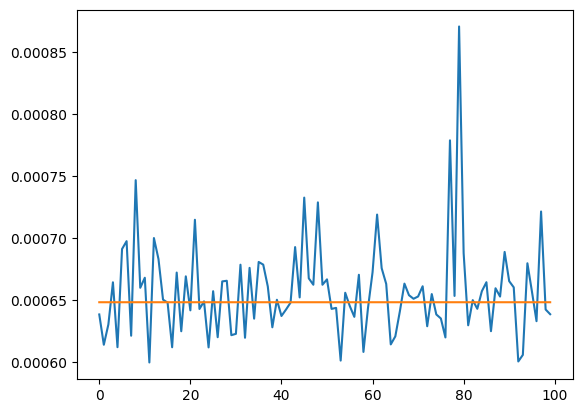

In [69]:
plt.plot(loss_train)
plt.plot(loss_validation)

### Trained with BBH

In [236]:
version = 'v1'
dInput = 200

In [237]:
n_BKG = len(realbkg)
n_BBH = len(realbbh)
n_SG = len(realsg)
n_GLITCH = len(realglitch)

In [238]:
# Beacuse there's already 20% of dataset reserved here, there's no meaning setting the testset. We only do
# training and validation here. 

rTrain = 1-rValidation

n_BKG_train = int(n_BKG * rTrain)
n_BBH_train = int(n_BBH * rTrain)
n_SG_train = int(n_SG * rTrain)
n_GLITCH_train = int(n_GLITCH * rTrain)

n_BKG_validation = int(n_BKG * rValidation)
n_BBH_validation = int(n_BBH * rValidation)
n_SG_validation = int(n_SG * rValidation)
n_GLITCH_validation = int(n_GLITCH * rValidation)

In [ ]:
# Beacuse there's already 20% of dataset reserved here, there's no meaning setting the testset. We only do
# training and validation here. 

rTrain = 1-rValidation

n_BKG_train = int(n_BKG * rTrain)
n_BBH_train = int(n_BBH * rTrain)
n_SG_train = int(n_SG * rTrain)
n_GLITCH_train = int(n_GLITCH * rTrain)

n_BKG_validation = int(n_BKG * rValidation)
n_BBH_validation = int(n_BBH * rValidation)
n_SG_validation = int(n_SG * rValidation)
n_GLITCH_validation = int(n_GLITCH * rValidation)


X_train = np.concatenate((realbkg[:n_BKG_train], 
                          realbbh[:n_BBH_train], 
                          realsg[:n_SG_train], 
                          realglitch[:n_GLITCH_train]), axis = 0)
target_train = np.concatenate((np.ones(n_BKG_train + n_BBH_train + n_SG_train), np.zeros(n_GLITCH_train)))

X_validation = np.concatenate((realbkg[-n_BKG_validation:], 
                          realbbh[-n_BBH_validation:], 
                          realsg[-n_SG_validation:], 
                          realglitch[-n_GLITCH_validation:]), axis = 0)
target_validation = np.concatenate((np.ones(n_BKG_validation + n_BBH_validation + n_SG_validation), np.zeros(n_GLITCH_validation)))


train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(target_train.reshape((len(target_train), 1))))
# test_dataset  = TensorDataset(torch.FloatTensor(X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))),  torch.FloatTensor(target_test.reshape((len(target_test), 1))))
valid_dataset = TensorDataset(torch.FloatTensor(X_validation), torch.FloatTensor(target_validation.reshape((len(target_validation), 1))))

trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
validationDataLoader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=True)

MemoryError: Unable to allocate 2.22 GiB for an array with shape (744233, 2, 200) and data type float64

In [239]:
X_train = realbbh[:n_BBH_train]
X_validation = realbbh[-n_BBH_validation:]

train_dataset = TensorDataset(torch.FloatTensor(X_train))
# test_dataset  = TensorDataset(torch.FloatTensor(X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))),  torch.FloatTensor(target_test.reshape((len(target_test), 1))))
valid_dataset = TensorDataset(torch.FloatTensor(X_validation))

trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
validationDataLoader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=True)

In [244]:
X_train.shape

(72000, 2, 200)

In [241]:
classifier = WaveletCNNAE(num_ifos=2, c_depth=5, n_chann=4, l1=32, l2=16).cuda()
print(sum(p.numel() for p in classifier.parameters() if p.requires_grad))

optimizer = optim.Adam(classifier.parameters(), lr=0.00005)
loss_func = nn.MSELoss().cuda()
loss_train = np.empty((epochs, ))
loss_validation = np.empty((epochs, ))

for epoch in range(epochs):

    t0 = time.time()
    classifier.train()
    for batchidx, x in enumerate(trainDataLoader):
        x = x[0].cuda()
        # print(x.shape)
        # tgt_index = tgt_index.cuda()
        output = classifier(x)
        loss = loss_func(output, x)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    classifier.eval()
    with torch.no_grad():
        val_loss = 0
        n_correct = 0;
        for batchidx, x in enumerate(validationDataLoader):
            x = x[0].cuda()
            # tgt_index = tgt_index.cuda()
            output = classifier(x)
            lossVal = loss_func(output, x)
            val_loss += lossVal.item()
            # n_correct += torch.eq(tgt_index, torch.argmax(output, dim=1)).sum().item()

        val_loss /= len(validationDataLoader)

    loss_train[epoch] = loss.item()
    loss_validation[epoch] = val_loss
    print('Epoch: %04d, Training loss=%f, Validation loss=%f, valid accuracy=%f' % (epoch+1, loss_train[epoch], val_loss, n_correct*1./len(X_validation)))
    print('Time for this epoch: ' + str(time.time() - t0))

#     print(time.time() - t0)

plt.plot(loss_train)
plt.plot(loss_validation)

torch.save(classifier.cuda(), "../Model_cached/Wavelet_model_AE"+version+"_GWAK_BBH_trained.pt")
# np.savetxt("../data/SupLearn/lossClassifierTraining_64-64-16.dat", [loss_train, loss_validation])

13006


Epoch: 0001, Training loss=0.042596, Validation loss=0.043087, valid accuracy=0.000000
Time for this epoch: 19.12697672843933
Epoch: 0002, Training loss=0.007014, Validation loss=0.007117, valid accuracy=0.000000
Time for this epoch: 18.92857599258423
Epoch: 0003, Training loss=0.005289, Validation loss=0.005290, valid accuracy=0.000000
Time for this epoch: 18.80646777153015
Epoch: 0004, Training loss=0.005043, Validation loss=0.005055, valid accuracy=0.000000
Time for this epoch: 18.751612424850464
Epoch: 0005, Training loss=0.005022, Validation loss=0.005009, valid accuracy=0.000000
Time for this epoch: 19.134216785430908
Epoch: 0006, Training loss=0.005001, Validation loss=0.005001, valid accuracy=0.000000
Time for this epoch: 18.81707763671875
Epoch: 0007, Training loss=0.005000, Validation loss=0.005000, valid accuracy=0.000000
Time for this epoch: 18.968008518218994
Epoch: 0008, Training loss=0.005000, Validation loss=0.005000, valid accuracy=0.000000
Time for this epoch: 18.8087

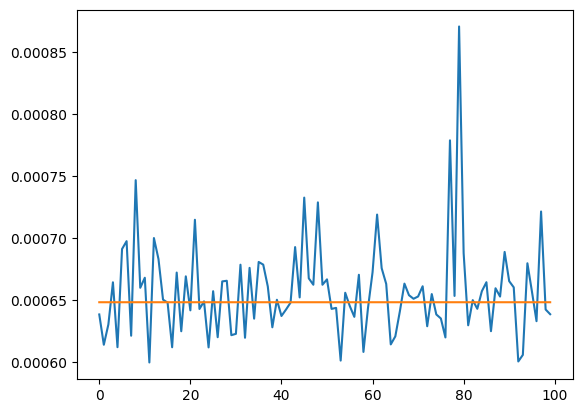

In [ ]:
plt.plot(loss_train)
plt.plot(loss_validation)

# Evaluating the model

## Supervised case

### Glitch trained

In [31]:
version = 'v1'

In [34]:
classifier = torch.load("../Model_cached/Wavelet_model_SL"+version+".pt")

In [35]:
classifier.cpu()

WaveletCNNSL(
  (cap_norm): GroupNorm(2, 2, eps=1e-05, affine=True)
  (Conv_In): Conv1d(2, 8, kernel_size=(1,), stride=(1,))
  (Conv_Out): Conv1d(8, 1, kernel_size=(1,), stride=(1,))
  (body_norm): GroupNorm(4, 8, eps=1e-05, affine=True)
  (end_norm): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (WaveNet_layers): ModuleList(
    (0): Conv1d(8, 8, kernel_size=(2,), stride=(1,))
    (1): Conv1d(8, 8, kernel_size=(2,), stride=(1,), dilation=(2,))
    (2): Conv1d(8, 8, kernel_size=(2,), stride=(1,), dilation=(4,))
    (3): Conv1d(8, 8, kernel_size=(2,), stride=(1,), dilation=(8,))
    (4): Conv1d(8, 8, kernel_size=(2,), stride=(1,), dilation=(16,))
  )
  (L1_norm): BatchNorm1d(169, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (L1): Linear(in_features=169, out_features=64, bias=True)
  (L2_norm): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (L2): Linear(in_features=64, out_features=16, bias=True)
 

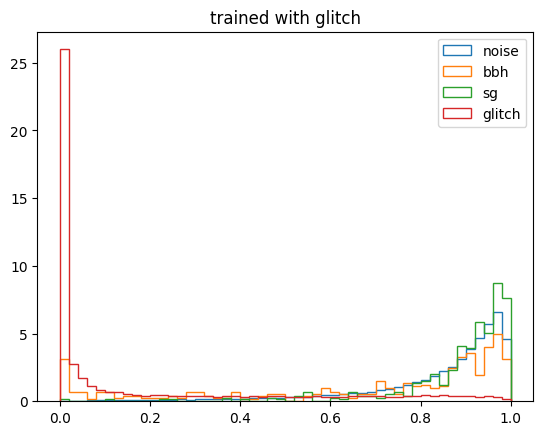

In [37]:
dcd_bkg = nn.Sigmoid()(classifier(torch.FloatTensor(realbkg_reserved))).detach().numpy()
dcd_bbh = nn.Sigmoid()(classifier(torch.FloatTensor(realbbh_reserved))).detach().numpy()
dcd_sg = nn.Sigmoid()(classifier(torch.FloatTensor(realsg_reserved))).detach().numpy()
dcd_glitch = nn.Sigmoid()(classifier(torch.FloatTensor(realglitch_reserved))).detach().numpy()

foo = plt.hist(dcd_bkg, histtype="step", range=(0, 1), bins=50, density=True, label="noise")
foo = plt.hist(dcd_bbh, histtype="step", range=(0, 1), bins=50, density=True, label="bbh")
foo = plt.hist(dcd_sg, histtype="step", range=(0, 1), bins=50, density=True, label="sg")
foo = plt.hist(dcd_glitch, histtype="step", range=(0, 1), bins=50, density=True, label="glitch")
plt.title("trained with glitch")
# plt.axvline(c0["glitch"], color="k", linestyle="--")
plt.legend()

### Noise trained

In [46]:
version = 'v1'

In [ ]:
classifier = torch.load("../Model_cached/Wavelet_model_SL"+version+".pt")

In [47]:
classifier.cpu()

WaveletCNNSL(
  (cap_norm): GroupNorm(2, 2, eps=1e-05, affine=True)
  (Conv_In): Conv1d(2, 8, kernel_size=(1,), stride=(1,))
  (Conv_Out): Conv1d(8, 1, kernel_size=(1,), stride=(1,))
  (body_norm): GroupNorm(4, 8, eps=1e-05, affine=True)
  (end_norm): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (WaveNet_layers): ModuleList(
    (0): Conv1d(8, 8, kernel_size=(2,), stride=(1,))
    (1): Conv1d(8, 8, kernel_size=(2,), stride=(1,), dilation=(2,))
    (2): Conv1d(8, 8, kernel_size=(2,), stride=(1,), dilation=(4,))
    (3): Conv1d(8, 8, kernel_size=(2,), stride=(1,), dilation=(8,))
    (4): Conv1d(8, 8, kernel_size=(2,), stride=(1,), dilation=(16,))
  )
  (L1_norm): BatchNorm1d(169, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (L1): Linear(in_features=169, out_features=64, bias=True)
  (L2_norm): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (L2): Linear(in_features=64, out_features=16, bias=True)
 

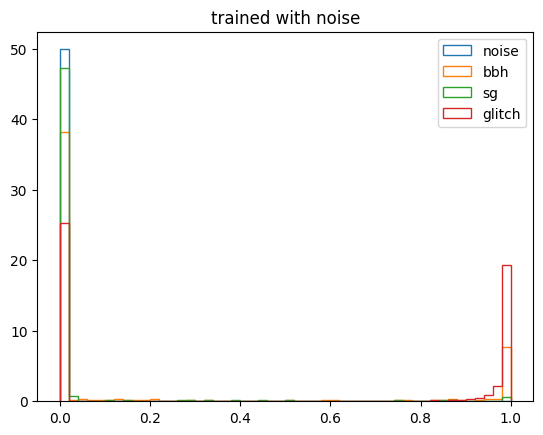

In [49]:
dcd_bkg = nn.Sigmoid()(classifier(torch.FloatTensor(realbkg_reserved))).detach().numpy()
dcd_bbh = nn.Sigmoid()(classifier(torch.FloatTensor(realbbh_reserved))).detach().numpy()
dcd_sg = nn.Sigmoid()(classifier(torch.FloatTensor(realsg_reserved))).detach().numpy()
dcd_glitch = nn.Sigmoid()(classifier(torch.FloatTensor(realglitch_reserved))).detach().numpy()

foo = plt.hist(dcd_bkg, histtype="step", range=(0, 1), bins=50, density=True, label="noise")
foo = plt.hist(dcd_bbh, histtype="step", range=(0, 1), bins=50, density=True, label="bbh")
foo = plt.hist(dcd_sg, histtype="step", range=(0, 1), bins=50, density=True, label="sg")
foo = plt.hist(dcd_glitch, histtype="step", range=(0, 1), bins=50, density=True, label="glitch")
plt.title("trained with noise")
# plt.axvline(c0["glitch"], color="k", linestyle="--")
plt.legend()

## Unsupervised case

### Glitch trained

In [19]:
version = 'v16'

In [20]:
classifier = torch.load("../Model_cached/Wavelet_model_glitchtrained_AE"+version+"_20_10.pt")

In [88]:
classifier.cpu()

WaveletCNNAE(
  (cap_norm): GroupNorm(1, 1, eps=1e-05, affine=True)
  (Conv_In_encode): Conv1d(1, 4, kernel_size=(1,), stride=(1,))
  (Conv_Out_encode): Conv1d(4, 1, kernel_size=(1,), stride=(1,))
  (Conv_In_decode): Conv1d(1, 4, kernel_size=(1,), stride=(1,))
  (Conv_Out_decode): Conv1d(4, 1, kernel_size=(1,), stride=(1,))
  (body_norm_encode): GroupNorm(4, 4, eps=1e-05, affine=True)
  (body_norm_decode): GroupNorm(4, 4, eps=1e-05, affine=True)
  (end_norm_encode): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (end_norm_decode): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (WaveNet_layers_encode): ModuleList(
    (0): Conv1d(4, 4, kernel_size=(2,), stride=(1,))
    (1): Conv1d(4, 4, kernel_size=(2,), stride=(1,), dilation=(2,))
    (2): Conv1d(4, 4, kernel_size=(2,), stride=(1,), dilation=(4,))
    (3): Conv1d(4, 4, kernel_size=(2,), stride=(1,), dilation=(8,))
    (4): Conv1d(4, 4, kernel_size=(2,), stride=(1,), d

In [58]:
classifier.cpu()

WaveletCNNAE(
  (cap_norm): GroupNorm(1, 1, eps=1e-05, affine=True)
  (Conv_In_encode): Conv1d(1, 4, kernel_size=(1,), stride=(1,))
  (Conv_Out_encode): Conv1d(4, 1, kernel_size=(1,), stride=(1,))
  (Conv_In_decode): Conv1d(1, 4, kernel_size=(1,), stride=(1,))
  (Conv_Out_decode): Conv1d(4, 1, kernel_size=(1,), stride=(1,))
  (body_norm_encode): GroupNorm(4, 4, eps=1e-05, affine=True)
  (body_norm_decode): GroupNorm(4, 4, eps=1e-05, affine=True)
  (end_norm_encode): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (end_norm_decode): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (WaveNet_layers_encode): ModuleList(
    (0): Conv1d(4, 4, kernel_size=(2,), stride=(1,))
    (1): Conv1d(4, 4, kernel_size=(2,), stride=(1,), dilation=(2,))
    (2): Conv1d(4, 4, kernel_size=(2,), stride=(1,), dilation=(4,))
    (3): Conv1d(4, 4, kernel_size=(2,), stride=(1,), dilation=(8,))
    (4): Conv1d(4, 4, kernel_size=(2,), stride=(1,), d

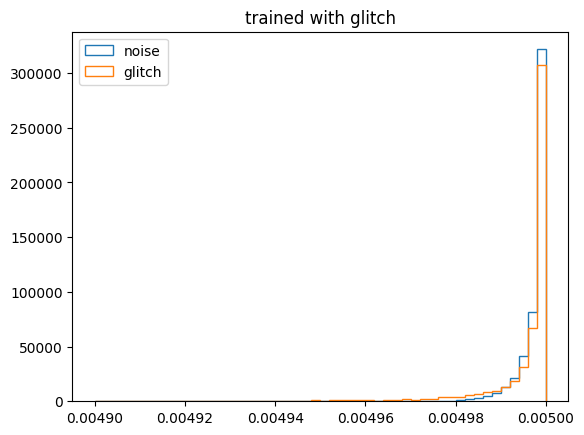

In [91]:
# Model version 17, Chia-Jui glitch trained, single detector, one channel DNN. Meaningless

dcd_bkg = classifier(torch.FloatTensor(realbkg_reserved)).detach().numpy().reshape(-1,200)
dcd_bbh = classifier(torch.FloatTensor(realbbh_reserved)).detach().numpy().reshape(-1,200)
dcd_sg = classifier(torch.FloatTensor(realsg_reserved)).detach().numpy().reshape(-1,200)
dcd_glitch = classifier(torch.FloatTensor(realglitch_reserved)).detach().numpy().reshape(-1,200)

foo = plt.hist(np.var(realbkg_reserved.reshape(-1,200)-dcd_bkg, axis=1), histtype="step", range=(0.0049, 0.005), bins=50, density=True, label="noise")
# foo = plt.hist(np.var(realbbh_reserved.reshape(-1,200)-dcd_bbh, axis=1), histtype="step", range=(0, 0.008), bins=50, density=True, label="bbh")
# foo = plt.hist(np.var(realsg_reserved.reshape(-1,200)-dcd_sg, axis=1), histtype="step", range=(0, 0.008), bins=50, density=True, label="sg")
foo = plt.hist(np.var(realglitch_reserved.reshape(-1,200)-dcd_glitch, axis=1), histtype="step", range=(0.0049, 0.005), bins=50, density=True, label="glitch")
plt.title("trained with glitch")
# plt.axvline(c0["glitch"], color="k", linestyle="--")
plt.legend()

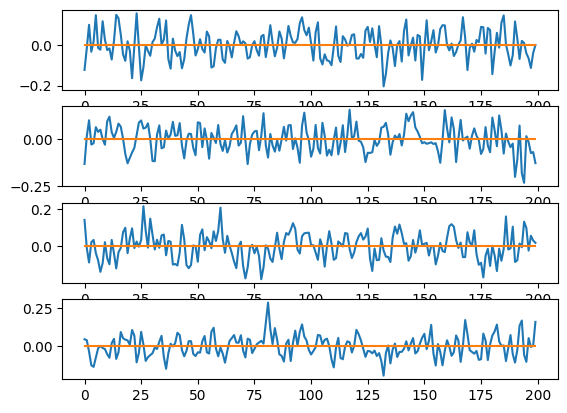

In [92]:
# Glitch version 17, Chia-Jui glitch, one channel, reconstruction waveform comparison

Reconstructed_Waveforms = {}
Initial_waveforms = {}

datatype_list = ['bkg', 'bbh', 'sg', 'glitch']

Reconstructed_Waveforms['bkg'] = classifier(torch.FloatTensor(realbkg_reserved)).detach().numpy()
Reconstructed_Waveforms['bbh'] = classifier(torch.FloatTensor(realbbh_reserved)).detach().numpy()
Reconstructed_Waveforms['sg'] = classifier(torch.FloatTensor(realsg_reserved)).detach().numpy()
Reconstructed_Waveforms['glitch'] = classifier(torch.FloatTensor(realglitch_reserved)).detach().numpy()

Initial_waveforms['bkg'] = realbkg_reserved
Initial_waveforms['bbh'] = realbbh_reserved
Initial_waveforms['sg'] = realsg_reserved
Initial_waveforms['glitch'] = realglitch_reserved

bkg_idx = 0
bbh_idx = 0
sg_idx = 0
glitch_idx = 200

idx = {'bkg':bkg_idx,
       'bbh':bbh_idx,
       'sg':sg_idx,
       'glitch':glitch_idx
       }

fig, axs = plt.subplots(4,1)

for j in range(len(datatype_list)):
    for i in range(1):
        axs[j].plot(Initial_waveforms[datatype_list[j]][idx[datatype_list[j]]][i])
        axs[j].plot(Reconstructed_Waveforms[datatype_list[j]][idx[datatype_list[j]]][i])
plt.show()


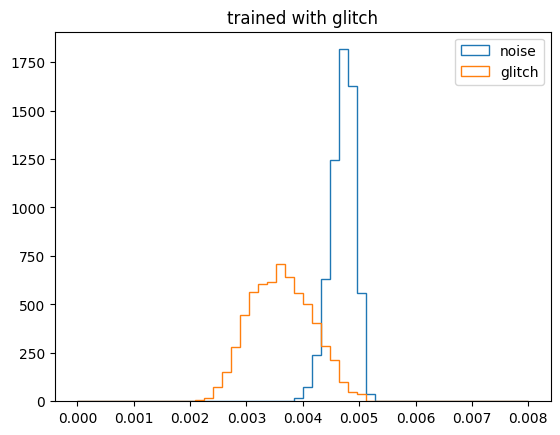

In [68]:
# Model version 16, Chia-Jui glitch trained, single detector, one channel DNN. The noise here is the 4ks

dcd_bkg = classifier(torch.FloatTensor(realbkg_reserved)).detach().numpy().reshape(-1,200)
dcd_bbh = classifier(torch.FloatTensor(realbbh_reserved)).detach().numpy().reshape(-1,200)
dcd_sg = classifier(torch.FloatTensor(realsg_reserved)).detach().numpy().reshape(-1,200)
dcd_glitch = classifier(torch.FloatTensor(realglitch_reserved)).detach().numpy().reshape(-1,200)

foo = plt.hist(np.var(realbkg_reserved.reshape(-1,200)-dcd_bkg, axis=1), histtype="step", range=(0, 0.008), bins=50, density=True, label="noise")
# foo = plt.hist(np.var(realbbh_reserved.reshape(-1,200)-dcd_bbh, axis=1), histtype="step", range=(0, 0.008), bins=50, density=True, label="bbh")
# foo = plt.hist(np.var(realsg_reserved.reshape(-1,200)-dcd_sg, axis=1), histtype="step", range=(0, 0.008), bins=50, density=True, label="sg")
foo = plt.hist(np.var(realglitch_reserved.reshape(-1,200)-dcd_glitch, axis=1), histtype="step", range=(0, 0.008), bins=50, density=True, label="glitch")
plt.title("trained with glitch")
# plt.axvline(c0["glitch"], color="k", linestyle="--")
plt.legend()

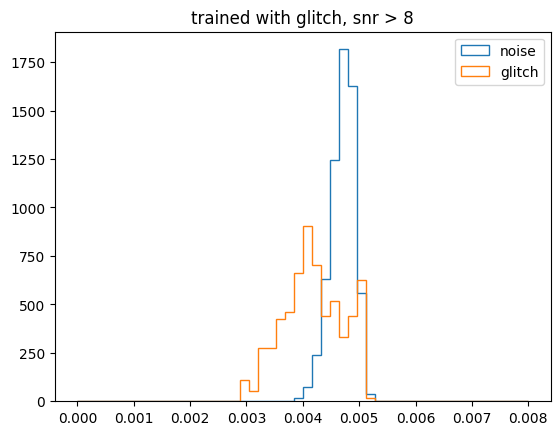

In [69]:
# Model version 16, Chia-Jui glitch trained, single detector, one channel DNN. The noise here is the 4ks

dcd_bkg = classifier(torch.FloatTensor(realbkg_reserved)).detach().numpy().reshape(-1,200)
dcd_bbh = classifier(torch.FloatTensor(realbbh_reserved)).detach().numpy().reshape(-1,200)
dcd_sg = classifier(torch.FloatTensor(realsg_reserved)).detach().numpy().reshape(-1,200)
dcd_glitch = classifier(torch.FloatTensor(realglitch_reserved[np.argwhere(realglitch_L_snr[-6000:]>8).flatten()])).detach().numpy().reshape(-1,200)

foo = plt.hist(np.var(realbkg_reserved.reshape(-1,200)-dcd_bkg, axis=1), histtype="step", range=(0, 0.008), bins=50, density=True, label="noise")
# foo = plt.hist(np.var(realbbh_reserved.reshape(-1,200)-dcd_bbh, axis=1), histtype="step", range=(0, 0.008), bins=50, density=True, label="bbh")
# foo = plt.hist(np.var(realsg_reserved.reshape(-1,200)-dcd_sg, axis=1), histtype="step", range=(0, 0.008), bins=50, density=True, label="sg")
foo = plt.hist(np.var(realglitch_reserved[np.argwhere(realglitch_L_snr[-6000:]>8).flatten()].reshape(-1,200)-dcd_glitch, axis=1), histtype="step", range=(0, 0.008), bins=50, density=True, label="glitch")
plt.title("trained with glitch, snr > 8")
# plt.axvline(c0["glitch"], color="k", linestyle="--")
plt.legend()

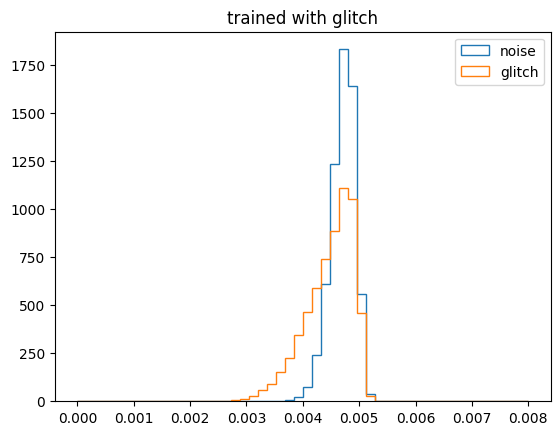

In [71]:
# Model version 16, Chia-Jui glitch trained, single detector, one channel DNN

dcd_bkg = classifier(torch.FloatTensor(realbkg)).detach().numpy().reshape(-1,200)
dcd_bbh = classifier(torch.FloatTensor(realbbh)).detach().numpy().reshape(-1,200)
dcd_sg = classifier(torch.FloatTensor(realsg)).detach().numpy().reshape(-1,200)
dcd_glitch = classifier(torch.FloatTensor(realglitch)).detach().numpy().reshape(-1,200)

foo = plt.hist(np.var(realbkg.reshape(-1,200)-dcd_bkg, axis=1), histtype="step", range=(0, 0.008), bins=50, density=True, label="noise")
# foo = plt.hist(np.var(realbbh.reshape(-1,200)-dcd_bbh, axis=1), histtype="step", range=(0, 0.008), bins=50, density=True, label="bbh")
# foo = plt.hist(np.var(realsg.reshape(-1,200)-dcd_sg, axis=1), histtype="step", range=(0, 0.008), bins=50, density=True, label="sg")
foo = plt.hist(np.var(realglitch.reshape(-1,200)-dcd_glitch, axis=1), histtype="step", range=(0, 0.008), bins=50, density=True, label="glitch")
plt.title("trained with glitch")
# plt.axvline(c0["glitch"], color="k", linestyle="--")
plt.legend()

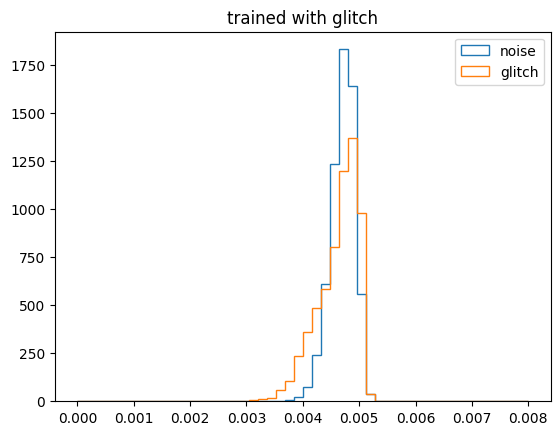

In [74]:
# Model version 16, Chia-Jui glitch trained, single detector, one channel DNN

dcd_bkg = classifier(torch.FloatTensor(realbkg)).detach().numpy().reshape(-1,200)
dcd_bbh = classifier(torch.FloatTensor(realbbh)).detach().numpy().reshape(-1,200)
dcd_sg = classifier(torch.FloatTensor(realsg)).detach().numpy().reshape(-1,200)
dcd_glitch = classifier(torch.FloatTensor(realglitch[np.argwhere(realglitch_L_snr[:-6000]>8).flatten()])).detach().numpy().reshape(-1,200)

foo = plt.hist(np.var(realbkg.reshape(-1,200)-dcd_bkg, axis=1), histtype="step", range=(0, 0.008), bins=50, density=True, label="noise")
# foo = plt.hist(np.var(realbbh.reshape(-1,200)-dcd_bbh, axis=1), histtype="step", range=(0, 0.008), bins=50, density=True, label="bbh")
# foo = plt.hist(np.var(realsg.reshape(-1,200)-dcd_sg, axis=1), histtype="step", range=(0, 0.008), bins=50, density=True, label="sg")
foo = plt.hist(np.var(realglitch[np.argwhere(realglitch_L_snr[:-6000]>8).flatten()].reshape(-1,200)-dcd_glitch, axis=1), histtype="step", range=(0, 0.008), bins=50, density=True, label="glitch")
plt.title("trained with glitch")
# plt.axvline(c0["glitch"], color="k", linestyle="--")
plt.legend()

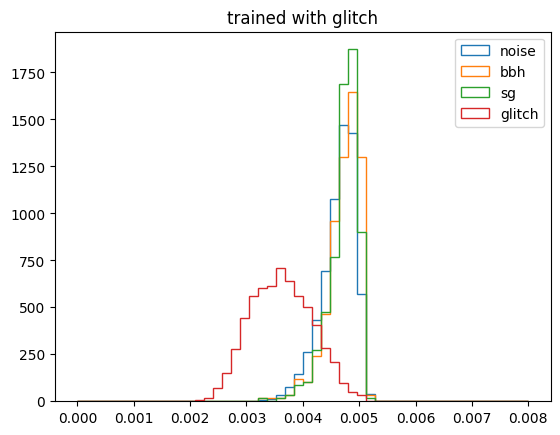

In [22]:
# Model version 16, Chia-Jui glitch trained, single detector, one channel DNN

dcd_bkg = classifier(torch.FloatTensor(realbkg_reserved)).detach().numpy().reshape(-1,200)
dcd_bbh = classifier(torch.FloatTensor(realbbh_reserved)).detach().numpy().reshape(-1,200)
dcd_sg = classifier(torch.FloatTensor(realsg_reserved)).detach().numpy().reshape(-1,200)
dcd_glitch = classifier(torch.FloatTensor(realglitch_reserved)).detach().numpy().reshape(-1,200)

foo = plt.hist(np.var(realbkg_reserved.reshape(-1,200)-dcd_bkg, axis=1), histtype="step", range=(0, 0.008), bins=50, density=True, label="noise")
foo = plt.hist(np.var(realbbh_reserved.reshape(-1,200)-dcd_bbh, axis=1), histtype="step", range=(0, 0.008), bins=50, density=True, label="bbh")
foo = plt.hist(np.var(realsg_reserved.reshape(-1,200)-dcd_sg, axis=1), histtype="step", range=(0, 0.008), bins=50, density=True, label="sg")
foo = plt.hist(np.var(realglitch_reserved.reshape(-1,200)-dcd_glitch, axis=1), histtype="step", range=(0, 0.008), bins=50, density=True, label="glitch")
plt.title("trained with glitch")
# plt.axvline(c0["glitch"], color="k", linestyle="--")
plt.legend()

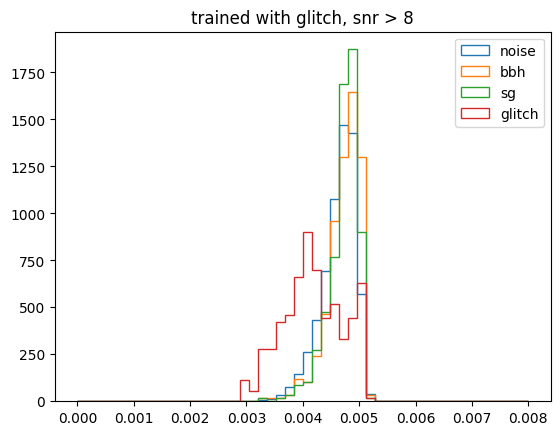

In [35]:
# Model version 16, Chia-Jui glitch trained, single detector, one channel DNN

dcd_bkg = classifier(torch.FloatTensor(realbkg_reserved)).detach().numpy().reshape(-1,200)
dcd_bbh = classifier(torch.FloatTensor(realbbh_reserved)).detach().numpy().reshape(-1,200)
dcd_sg = classifier(torch.FloatTensor(realsg_reserved)).detach().numpy().reshape(-1,200)
dcd_glitch = classifier(torch.FloatTensor(realglitch_reserved[np.argwhere(realglitch_L_snr[-6000:]>8).flatten()])).detach().numpy().reshape(-1,200)

foo = plt.hist(np.var(realbkg_reserved.reshape(-1,200)-dcd_bkg, axis=1), histtype="step", range=(0, 0.008), bins=50, density=True, label="noise")
foo = plt.hist(np.var(realbbh_reserved.reshape(-1,200)-dcd_bbh, axis=1), histtype="step", range=(0, 0.008), bins=50, density=True, label="bbh")
foo = plt.hist(np.var(realsg_reserved.reshape(-1,200)-dcd_sg, axis=1), histtype="step", range=(0, 0.008), bins=50, density=True, label="sg")
foo = plt.hist(np.var(realglitch_reserved[np.argwhere(realglitch_L_snr[-6000:]>8).flatten()].reshape(-1,200)-dcd_glitch, axis=1), histtype="step", range=(0, 0.008), bins=50, density=True, label="glitch")
plt.title("trained with glitch, snr > 8")
# plt.axvline(c0["glitch"], color="k", linestyle="--")
plt.legend()

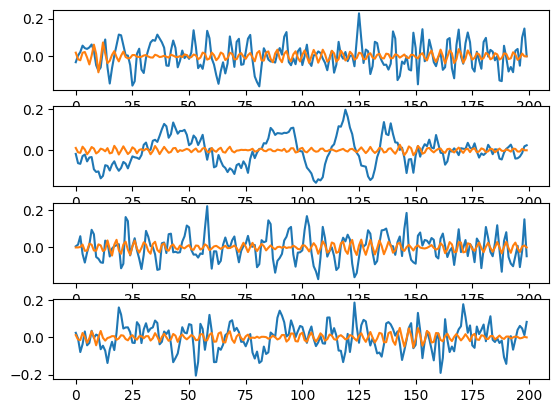

In [34]:
# Glitch version 16, Chia-Jui glitch, one channel, reconstruction waveform comparison

Reconstructed_Waveforms = {}
Initial_waveforms = {}

datatype_list = ['bkg', 'bbh', 'sg', 'glitch']

Reconstructed_Waveforms['bkg'] = classifier(torch.FloatTensor(realbkg_reserved)).detach().numpy()
Reconstructed_Waveforms['bbh'] = classifier(torch.FloatTensor(realbbh_reserved)).detach().numpy()
Reconstructed_Waveforms['sg'] = classifier(torch.FloatTensor(realsg_reserved)).detach().numpy()
Reconstructed_Waveforms['glitch'] = classifier(torch.FloatTensor(realglitch_reserved)).detach().numpy()

Initial_waveforms['bkg'] = realbkg_reserved
Initial_waveforms['bbh'] = realbbh_reserved
Initial_waveforms['sg'] = realsg_reserved
Initial_waveforms['glitch'] = realglitch_reserved

bkg_idx = 0
bbh_idx = 0
sg_idx = 0
glitch_idx = 200

idx = {'bkg':bkg_idx,
       'bbh':bbh_idx,
       'sg':sg_idx,
       'glitch':glitch_idx
       }

fig, axs = plt.subplots(4,1)

for j in range(len(datatype_list)):
    for i in range(1):
        axs[j].plot(Initial_waveforms[datatype_list[j]][idx[datatype_list[j]]][i])
        axs[j].plot(Reconstructed_Waveforms[datatype_list[j]][idx[datatype_list[j]]][i])
plt.show()


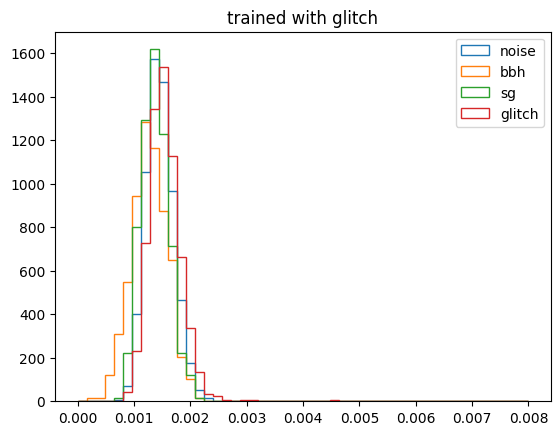

In [328]:
# Model version 14, GWAK glitch trained, single detector, no DNN

dcd_bkg = classifier(torch.FloatTensor(realbkg_reserved)).detach().numpy().reshape(-1,200)
dcd_bbh = classifier(torch.FloatTensor(realbbh_reserved)).detach().numpy().reshape(-1,200)
dcd_sg = classifier(torch.FloatTensor(realsg_reserved)).detach().numpy().reshape(-1,200)
dcd_glitch = classifier(torch.FloatTensor(realglitch_reserved)).detach().numpy().reshape(-1,200)

foo = plt.hist(np.var(realbkg_reserved.reshape(-1,200)-dcd_bkg, axis=1), histtype="step", range=(0, 0.008), bins=50, density=True, label="noise")
foo = plt.hist(np.var(realbbh_reserved.reshape(-1,200)-dcd_bbh, axis=1), histtype="step", range=(0, 0.008), bins=50, density=True, label="bbh")
foo = plt.hist(np.var(realsg_reserved.reshape(-1,200)-dcd_sg, axis=1), histtype="step", range=(0, 0.008), bins=50, density=True, label="sg")
foo = plt.hist(np.var(realglitch_reserved.reshape(-1,200)-dcd_glitch, axis=1), histtype="step", range=(0, 0.008), bins=50, density=True, label="glitch")
plt.title("trained with glitch")
# plt.axvline(c0["glitch"], color="k", linestyle="--")
plt.legend()

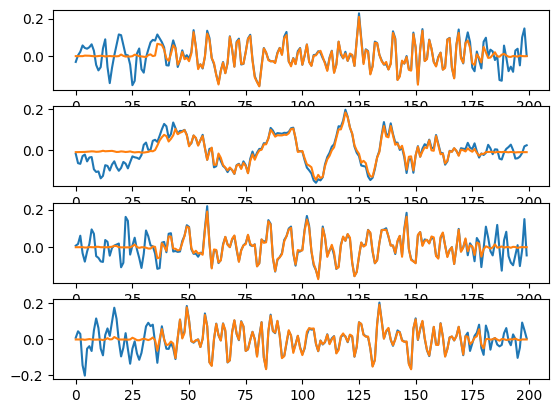

In [329]:
# Glitch version 14, GWAK noise, one channel, reconstruction waveform comparison

Reconstructed_Waveforms = {}
Initial_waveforms = {}

datatype_list = ['bkg', 'bbh', 'sg', 'glitch']

Reconstructed_Waveforms['bkg'] = classifier(torch.FloatTensor(realbkg_reserved)).detach().numpy()
Reconstructed_Waveforms['bbh'] = classifier(torch.FloatTensor(realbbh_reserved)).detach().numpy()
Reconstructed_Waveforms['sg'] = classifier(torch.FloatTensor(realsg_reserved)).detach().numpy()
Reconstructed_Waveforms['glitch'] = classifier(torch.FloatTensor(realglitch_reserved)).detach().numpy()

Initial_waveforms['bkg'] = realbkg_reserved
Initial_waveforms['bbh'] = realbbh_reserved
Initial_waveforms['sg'] = realsg_reserved
Initial_waveforms['glitch'] = realglitch_reserved

bkg_idx = 0
bbh_idx = 0
sg_idx = 0
glitch_idx = 0

idx = {'bkg':bkg_idx,
       'bbh':bbh_idx,
       'sg':sg_idx,
       'glitch':glitch_idx
       }

fig, axs = plt.subplots(4,1)

for j in range(len(datatype_list)):
    for i in range(1):
        axs[j].plot(Initial_waveforms[datatype_list[j]][idx[datatype_list[j]]][i])
        axs[j].plot(Reconstructed_Waveforms[datatype_list[j]][idx[datatype_list[j]]][i])
plt.show()


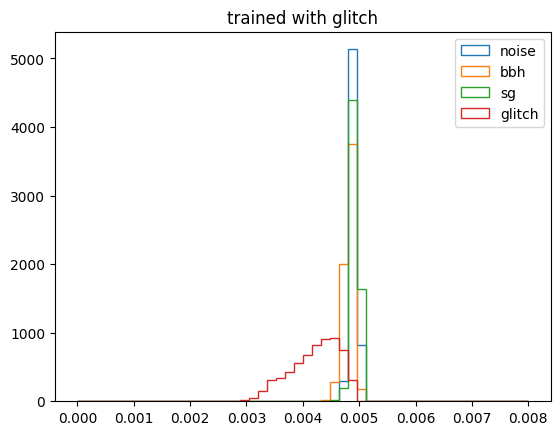

In [283]:
# Model version 13, GWAK glitch trained, one channel for DNN layers

dcd_bkg = classifier(torch.FloatTensor(realbkg_reserved)).detach().numpy().reshape(-1,400)
dcd_bbh = classifier(torch.FloatTensor(realbbh_reserved)).detach().numpy().reshape(-1,400)
dcd_sg = classifier(torch.FloatTensor(realsg_reserved)).detach().numpy().reshape(-1,400)
dcd_glitch = classifier(torch.FloatTensor(realglitch_reserved)).detach().numpy().reshape(-1,400)

foo = plt.hist(np.var(realbkg_reserved.reshape(-1,400)-dcd_bkg, axis=1), histtype="step", range=(0, 0.008), bins=50, density=True, label="noise")
foo = plt.hist(np.var(realbbh_reserved.reshape(-1,400)-dcd_bbh, axis=1), histtype="step", range=(0, 0.008), bins=50, density=True, label="bbh")
foo = plt.hist(np.var(realsg_reserved.reshape(-1,400)-dcd_sg, axis=1), histtype="step", range=(0, 0.008), bins=50, density=True, label="sg")
foo = plt.hist(np.var(realglitch_reserved.reshape(-1,400)-dcd_glitch, axis=1), histtype="step", range=(0, 0.008), bins=50, density=True, label="glitch")
plt.title("trained with glitch")
# plt.axvline(c0["glitch"], color="k", linestyle="--")
plt.legend()

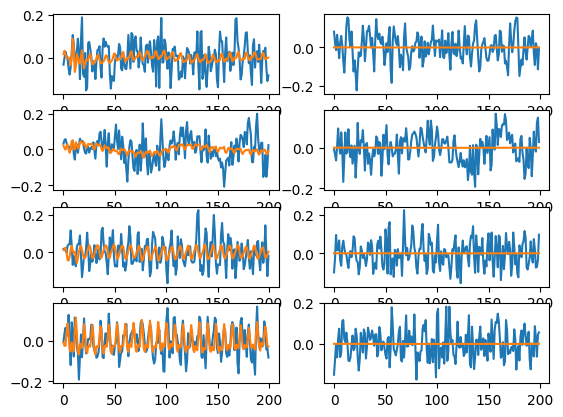

In [284]:
# Glitch version 13, GWAK noise, one channel, reconstruction waveform comparison

Reconstructed_Waveforms = {}
Initial_waveforms = {}

datatype_list = ['bkg', 'bbh', 'sg', 'glitch']

Reconstructed_Waveforms['bkg'] = classifier(torch.FloatTensor(realbkg_reserved)).detach().numpy()
Reconstructed_Waveforms['bbh'] = classifier(torch.FloatTensor(realbbh_reserved)).detach().numpy()
Reconstructed_Waveforms['sg'] = classifier(torch.FloatTensor(realsg_reserved)).detach().numpy()
Reconstructed_Waveforms['glitch'] = classifier(torch.FloatTensor(realglitch_reserved)).detach().numpy()

Initial_waveforms['bkg'] = realbkg_reserved
Initial_waveforms['bbh'] = realbbh_reserved
Initial_waveforms['sg'] = realsg_reserved
Initial_waveforms['glitch'] = realglitch_reserved

bkg_idx = 0
bbh_idx = 0
sg_idx = 0
glitch_idx = 0

idx = {'bkg':bkg_idx,
       'bbh':bbh_idx,
       'sg':sg_idx,
       'glitch':glitch_idx
       }

fig, axs = plt.subplots(4,2)

for j in range(len(datatype_list)):
    for i in range(2):
        axs[j,i].plot(Initial_waveforms[datatype_list[j]][idx[datatype_list[j]]][i])
        axs[j,i].plot(Reconstructed_Waveforms[datatype_list[j]][idx[datatype_list[j]]][i])
plt.show()


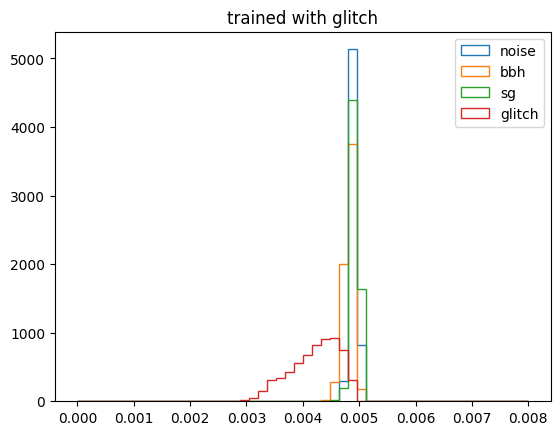

In [220]:
# Model version 13, GWAK glitch trained, one channel for DNN layers

dcd_bkg = classifier(torch.FloatTensor(realbkg_reserved)).detach().numpy().reshape(-1,400)
dcd_bbh = classifier(torch.FloatTensor(realbbh_reserved)).detach().numpy().reshape(-1,400)
dcd_sg = classifier(torch.FloatTensor(realsg_reserved)).detach().numpy().reshape(-1,400)
dcd_glitch = classifier(torch.FloatTensor(realglitch_reserved)).detach().numpy().reshape(-1,400)

foo = plt.hist(np.var(realbkg_reserved.reshape(-1,400)-dcd_bkg, axis=1), histtype="step", range=(0, 0.008), bins=50, density=True, label="noise")
foo = plt.hist(np.var(realbbh_reserved.reshape(-1,400)-dcd_bbh, axis=1), histtype="step", range=(0, 0.008), bins=50, density=True, label="bbh")
foo = plt.hist(np.var(realsg_reserved.reshape(-1,400)-dcd_sg, axis=1), histtype="step", range=(0, 0.008), bins=50, density=True, label="sg")
foo = plt.hist(np.var(realglitch_reserved.reshape(-1,400)-dcd_glitch, axis=1), histtype="step", range=(0, 0.008), bins=50, density=True, label="glitch")
plt.title("trained with glitch")
# plt.axvline(c0["glitch"], color="k", linestyle="--")
plt.legend()

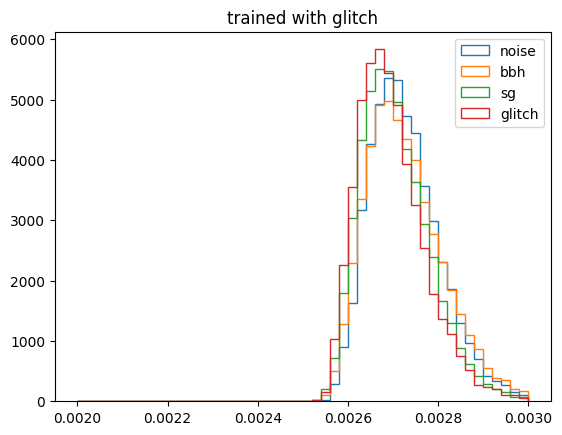

In [176]:
# Model version 12, GWAK glitch trained, No DNN layers

dcd_bkg = classifier(torch.FloatTensor(realbkg_reserved)).detach().numpy().reshape(-1,400)
dcd_bbh = classifier(torch.FloatTensor(realbbh_reserved)).detach().numpy().reshape(-1,400)
dcd_sg = classifier(torch.FloatTensor(realsg_reserved)).detach().numpy().reshape(-1,400)
dcd_glitch = classifier(torch.FloatTensor(realglitch_reserved)).detach().numpy().reshape(-1,400)

foo = plt.hist(np.var(realbkg_reserved.reshape(-1,400)-dcd_bkg, axis=1), histtype="step", range=(0.002, 0.003), bins=50, density=True, label="noise")
foo = plt.hist(np.var(realbbh_reserved.reshape(-1,400)-dcd_bbh, axis=1), histtype="step", range=(0.002, 0.003), bins=50, density=True, label="bbh")
foo = plt.hist(np.var(realsg_reserved.reshape(-1,400)-dcd_sg, axis=1), histtype="step", range=(0.002, 0.003), bins=50, density=True, label="sg")
foo = plt.hist(np.var(realglitch_reserved.reshape(-1,400)-dcd_glitch, axis=1), histtype="step", range=(0.002, 0.003), bins=50, density=True, label="glitch")
plt.title("trained with glitch")
# plt.axvline(c0["glitch"], color="k", linestyle="--")
plt.legend()

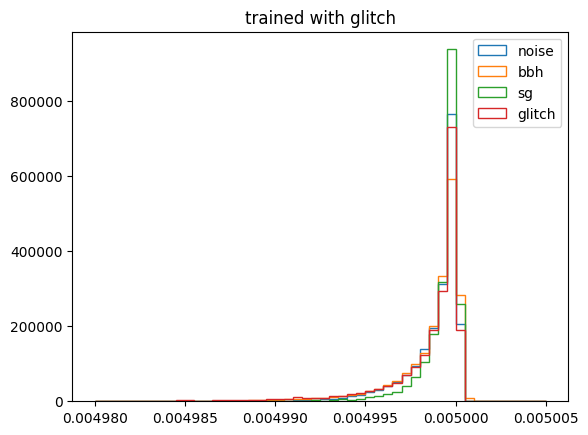

In [227]:
# Model version 11, glitch trained, multi-channel

dcd_bkg = classifier(torch.FloatTensor(realbkg_reserved)).detach().numpy().reshape(-1,400)
dcd_bbh = classifier(torch.FloatTensor(realbbh_reserved)).detach().numpy().reshape(-1,400)
dcd_sg = classifier(torch.FloatTensor(realsg_reserved)).detach().numpy().reshape(-1,400)
dcd_glitch = classifier(torch.FloatTensor(realglitch_reserved)).detach().numpy().reshape(-1,400)

foo = plt.hist(np.var(realbkg_reserved.reshape(-1,400)-dcd_bkg, axis=1), histtype="step", range=(0.00498, 0.005005), bins=50, density=True, label="noise")
foo = plt.hist(np.var(realbbh_reserved.reshape(-1,400)-dcd_bbh, axis=1), histtype="step", range=(0.00498, 0.005005), bins=50, density=True, label="bbh")
foo = plt.hist(np.var(realsg_reserved.reshape(-1,400)-dcd_sg, axis=1), histtype="step", range=(0.00498, 0.005005), bins=50, density=True, label="sg")
foo = plt.hist(np.var(realglitch_reserved.reshape(-1,400)-dcd_glitch, axis=1), histtype="step", range=(0.00498, 0.005005), bins=50, density=True, label="glitch")
plt.title("trained with glitch")
# plt.axvline(c0["glitch"], color="k", linestyle="--")
plt.legend()

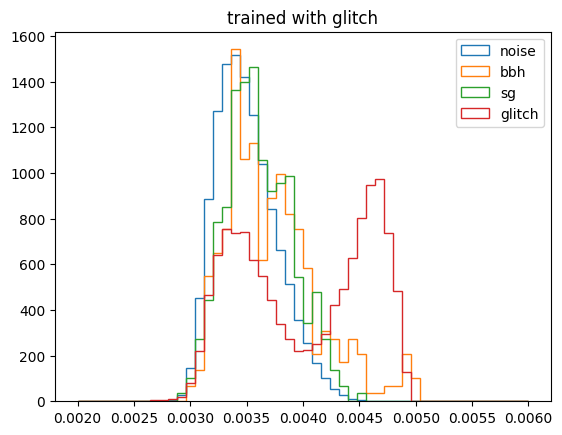

In [198]:
# Model version 10, glitch trained, one channel

dcd_bkg = classifier(torch.FloatTensor(realbkg_reserved)).detach().numpy().reshape(-1,400)
dcd_bbh = classifier(torch.FloatTensor(realbbh_reserved)).detach().numpy().reshape(-1,400)
dcd_sg = classifier(torch.FloatTensor(realsg_reserved)).detach().numpy().reshape(-1,400)
dcd_glitch = classifier(torch.FloatTensor(realglitch_reserved)).detach().numpy().reshape(-1,400)

foo = plt.hist(np.var(realbkg_reserved.reshape(-1,400)-dcd_bkg, axis=1), histtype="step", range=(0.002, 0.006), bins=50, density=True, label="noise")
foo = plt.hist(np.var(realbbh_reserved.reshape(-1,400)-dcd_bbh, axis=1), histtype="step", range=(0.002, 0.006), bins=50, density=True, label="bbh")
foo = plt.hist(np.var(realsg_reserved.reshape(-1,400)-dcd_sg, axis=1), histtype="step", range=(0.002, 0.006), bins=50, density=True, label="sg")
foo = plt.hist(np.var(realglitch_reserved.reshape(-1,400)-dcd_glitch, axis=1), histtype="step", range=(0.002, 0.006), bins=50, density=True, label="glitch")
plt.title("trained with glitch")
# plt.axvline(c0["glitch"], color="k", linestyle="--")
plt.legend()

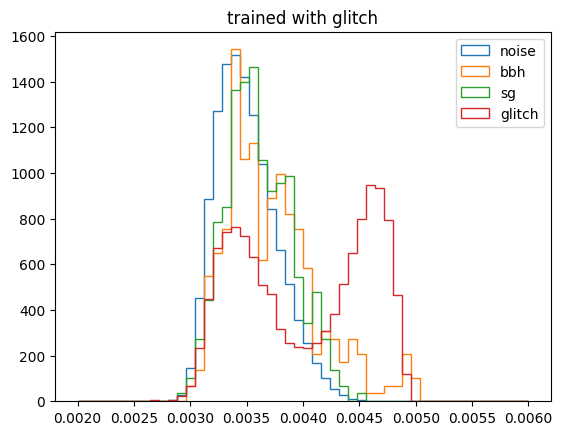

In [304]:
# Model version 10, glitch trained, one channel

dcd_bkg = classifier(torch.FloatTensor(realbkg_reserved)).detach().numpy().reshape(-1,400)
dcd_bbh = classifier(torch.FloatTensor(realbbh_reserved)).detach().numpy().reshape(-1,400)
dcd_sg = classifier(torch.FloatTensor(realsg_reserved)).detach().numpy().reshape(-1,400)
dcd_glitch = classifier(torch.FloatTensor(realglitch_reserved)).detach().numpy().reshape(-1,400)

foo = plt.hist(np.var(realbkg_reserved.reshape(-1,400)-dcd_bkg, axis=1), histtype="step", range=(0.002, 0.006), bins=50, density=True, label="noise")
foo = plt.hist(np.var(realbbh_reserved.reshape(-1,400)-dcd_bbh, axis=1), histtype="step", range=(0.002, 0.006), bins=50, density=True, label="bbh")
foo = plt.hist(np.var(realsg_reserved.reshape(-1,400)-dcd_sg, axis=1), histtype="step", range=(0.002, 0.006), bins=50, density=True, label="sg")
foo = plt.hist(np.var(realglitch_reserved.reshape(-1,400)-dcd_glitch, axis=1), histtype="step", range=(0.002, 0.006), bins=50, density=True, label="glitch")
plt.title("trained with glitch")
# plt.axvline(c0["glitch"], color="k", linestyle="--")
plt.legend()

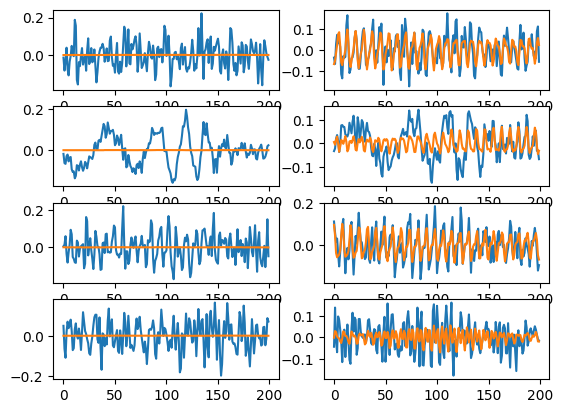

In [305]:
# Glitch version 10, Chia-Jui glitch, one channel, reconstruction waveform comparison

Reconstructed_Waveforms = {}
Initial_waveforms = {}

datatype_list = ['bkg', 'bbh', 'sg', 'glitch']

Reconstructed_Waveforms['bkg'] = classifier(torch.FloatTensor(realbkg_reserved)).detach().numpy()
Reconstructed_Waveforms['bbh'] = classifier(torch.FloatTensor(realbbh_reserved)).detach().numpy()
Reconstructed_Waveforms['sg'] = classifier(torch.FloatTensor(realsg_reserved)).detach().numpy()
Reconstructed_Waveforms['glitch'] = classifier(torch.FloatTensor(realglitch_reserved)).detach().numpy()

Initial_waveforms['bkg'] = realbkg_reserved
Initial_waveforms['bbh'] = realbbh_reserved
Initial_waveforms['sg'] = realsg_reserved
Initial_waveforms['glitch'] = realglitch_reserved

bkg_idx = 0
bbh_idx = 0
sg_idx = 0
glitch_idx = 0

idx = {'bkg':bkg_idx,
       'bbh':bbh_idx,
       'sg':sg_idx,
       'glitch':glitch_idx
       }

fig, axs = plt.subplots(4,2)

for j in range(len(datatype_list)):
    for i in range(2):
        axs[j,i].plot(Initial_waveforms[datatype_list[j]][idx[datatype_list[j]]][i])
        axs[j,i].plot(Reconstructed_Waveforms[datatype_list[j]][idx[datatype_list[j]]][i])
plt.show()


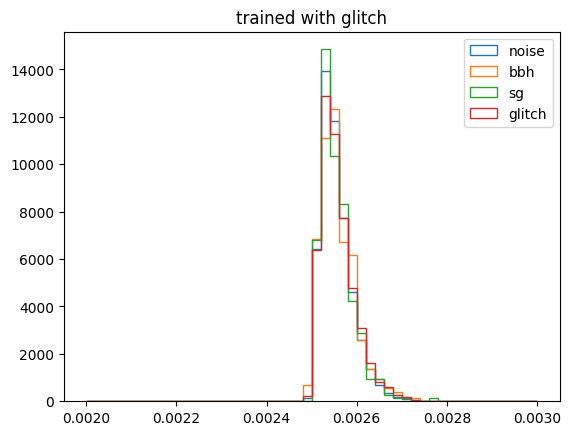

In [158]:
# Model version 9, glitch trained, No DNN layers

dcd_bkg = classifier(torch.FloatTensor(realbkg_reserved)).detach().numpy().reshape(-1,400)
dcd_bbh = classifier(torch.FloatTensor(realbbh_reserved)).detach().numpy().reshape(-1,400)
dcd_sg = classifier(torch.FloatTensor(realsg_reserved)).detach().numpy().reshape(-1,400)
dcd_glitch = classifier(torch.FloatTensor(realglitch_reserved)).detach().numpy().reshape(-1,400)

foo = plt.hist(np.var(realbkg_reserved.reshape(-1,400)-dcd_bkg, axis=1), histtype="step", range=(0.002, 0.003), bins=50, density=True, label="noise")
foo = plt.hist(np.var(realbbh_reserved.reshape(-1,400)-dcd_bbh, axis=1), histtype="step", range=(0.002, 0.003), bins=50, density=True, label="bbh")
foo = plt.hist(np.var(realsg_reserved.reshape(-1,400)-dcd_sg, axis=1), histtype="step", range=(0.002, 0.003), bins=50, density=True, label="sg")
foo = plt.hist(np.var(realglitch_reserved.reshape(-1,400)-dcd_glitch, axis=1), histtype="step", range=(0.002, 0.003), bins=50, density=True, label="glitch")
plt.title("trained with glitch")
# plt.axvline(c0["glitch"], color="k", linestyle="--")
plt.legend()

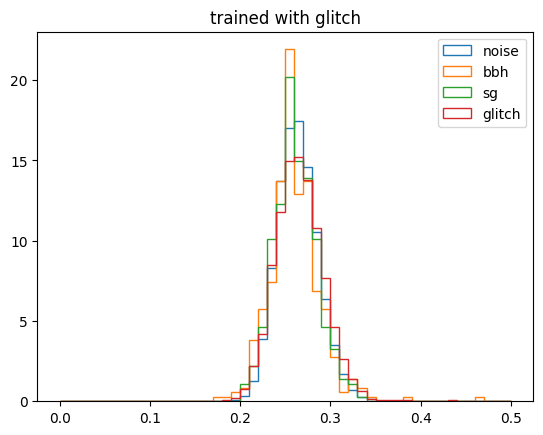

In [120]:
# Model version 8, glitch trained, No DNN layers

dcd_bkg = classifier(torch.FloatTensor(realbkg_reserved)).detach().numpy().reshape(-1,400)
dcd_bbh = classifier(torch.FloatTensor(realbbh_reserved)).detach().numpy().reshape(-1,400)
dcd_sg = classifier(torch.FloatTensor(realsg_reserved)).detach().numpy().reshape(-1,400)
dcd_glitch = classifier(torch.FloatTensor(realglitch_reserved)).detach().numpy().reshape(-1,400)

foo = plt.hist(np.var(realbkg_reserved.reshape(-1,400)-dcd_bkg, axis=1), histtype="step", range=(0, 0.5), bins=50, density=True, label="noise")
foo = plt.hist(np.var(realbbh_reserved.reshape(-1,400)-dcd_bbh, axis=1), histtype="step", range=(0, 0.5), bins=50, density=True, label="bbh")
foo = plt.hist(np.var(realsg_reserved.reshape(-1,400)-dcd_sg, axis=1), histtype="step", range=(0, 0.5), bins=50, density=True, label="sg")
foo = plt.hist(np.var(realglitch_reserved.reshape(-1,400)-dcd_glitch, axis=1), histtype="step", range=(0, 0.5), bins=50, density=True, label="glitch")
plt.title("trained with glitch")
# plt.axvline(c0["glitch"], color="k", linestyle="--")
plt.legend()

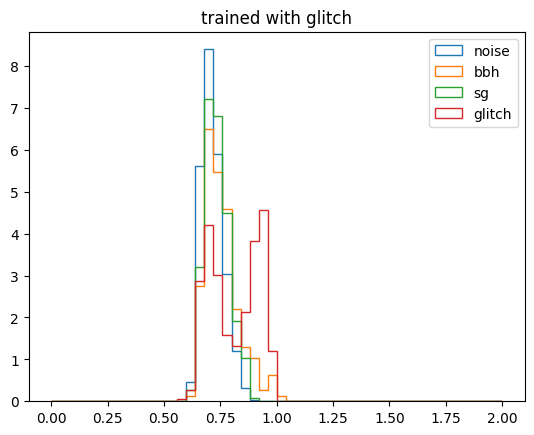

In [111]:
# Model version 7, glitch trained, 32-8, one channel, depth increased

dcd_bkg = classifier(torch.FloatTensor(realbkg_reserved)).detach().numpy().reshape(-1,400)
dcd_bbh = classifier(torch.FloatTensor(realbbh_reserved)).detach().numpy().reshape(-1,400)
dcd_sg = classifier(torch.FloatTensor(realsg_reserved)).detach().numpy().reshape(-1,400)
dcd_glitch = classifier(torch.FloatTensor(realglitch_reserved)).detach().numpy().reshape(-1,400)

foo = plt.hist(np.var(realbkg_reserved.reshape(-1,400)-dcd_bkg, axis=1), histtype="step", range=(0, 2), bins=50, density=True, label="noise")
foo = plt.hist(np.var(realbbh_reserved.reshape(-1,400)-dcd_bbh, axis=1), histtype="step", range=(0, 2), bins=50, density=True, label="bbh")
foo = plt.hist(np.var(realsg_reserved.reshape(-1,400)-dcd_sg, axis=1), histtype="step", range=(0, 2), bins=50, density=True, label="sg")
foo = plt.hist(np.var(realglitch_reserved.reshape(-1,400)-dcd_glitch, axis=1), histtype="step", range=(0, 2), bins=50, density=True, label="glitch")
plt.title("trained with glitch")
# plt.axvline(c0["glitch"], color="k", linestyle="--")
plt.legend()

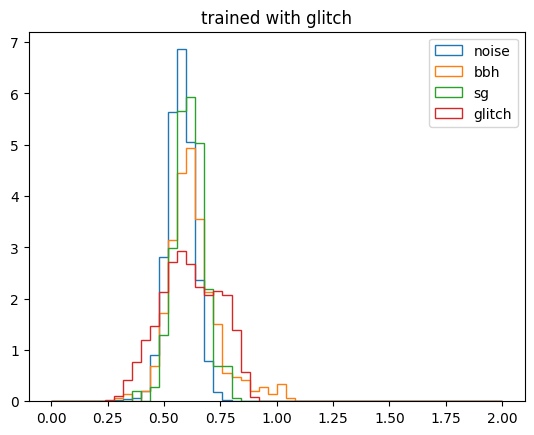

In [101]:
# Model version 5, glitch trained, 32-8, multi-channel

dcd_bkg = classifier(torch.FloatTensor(realbkg_reserved)).detach().numpy().reshape(-1,400)
dcd_bbh = classifier(torch.FloatTensor(realbbh_reserved)).detach().numpy().reshape(-1,400)
dcd_sg = classifier(torch.FloatTensor(realsg_reserved)).detach().numpy().reshape(-1,400)
dcd_glitch = classifier(torch.FloatTensor(realglitch_reserved)).detach().numpy().reshape(-1,400)

foo = plt.hist(np.var(realbkg_reserved.reshape(-1,400)-dcd_bkg, axis=1), histtype="step", range=(0, 2), bins=50, density=True, label="noise")
foo = plt.hist(np.var(realbbh_reserved.reshape(-1,400)-dcd_bbh, axis=1), histtype="step", range=(0, 2), bins=50, density=True, label="bbh")
foo = plt.hist(np.var(realsg_reserved.reshape(-1,400)-dcd_sg, axis=1), histtype="step", range=(0, 2), bins=50, density=True, label="sg")
foo = plt.hist(np.var(realglitch_reserved.reshape(-1,400)-dcd_glitch, axis=1), histtype="step", range=(0, 2), bins=50, density=True, label="glitch")
plt.title("trained with glitch")
# plt.axvline(c0["glitch"], color="k", linestyle="--")
plt.legend()

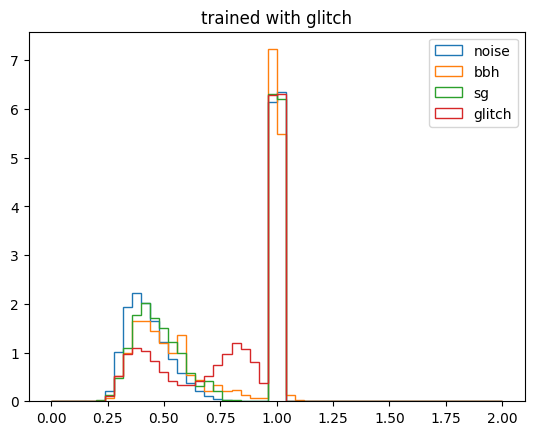

In [85]:
dcd_bkg = classifier(torch.FloatTensor(realbkg_reserved)).detach().numpy().reshape(-1,200)
dcd_bbh = classifier(torch.FloatTensor(realbbh_reserved)).detach().numpy().reshape(-1,200)
dcd_sg = classifier(torch.FloatTensor(realsg_reserved)).detach().numpy().reshape(-1,200)
dcd_glitch = classifier(torch.FloatTensor(realglitch_reserved)).detach().numpy().reshape(-1,200)

foo = plt.hist(np.var(realbkg_reserved.reshape(-1,200)-dcd_bkg, axis=1), histtype="step", range=(0, 2), bins=50, density=True, label="noise")
foo = plt.hist(np.var(realbbh_reserved.reshape(-1,200)-dcd_bbh, axis=1), histtype="step", range=(0, 2), bins=50, density=True, label="bbh")
foo = plt.hist(np.var(realsg_reserved.reshape(-1,200)-dcd_sg, axis=1), histtype="step", range=(0, 2), bins=50, density=True, label="sg")
foo = plt.hist(np.var(realglitch_reserved.reshape(-1,200)-dcd_glitch, axis=1), histtype="step", range=(0, 2), bins=50, density=True, label="glitch")
plt.title("trained with glitch")
# plt.axvline(c0["glitch"], color="k", linestyle="--")
plt.legend()

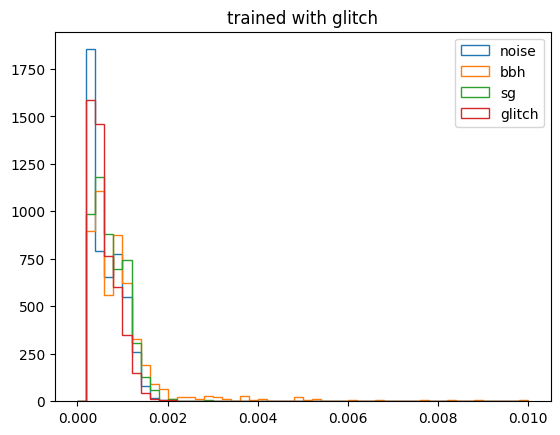

In [59]:
dcd_bkg = classifier(torch.FloatTensor(realbkg_reserved)).detach().numpy().reshape(-1,200)
dcd_bbh = classifier(torch.FloatTensor(realbbh_reserved)).detach().numpy().reshape(-1,200)
dcd_sg = classifier(torch.FloatTensor(realsg_reserved)).detach().numpy().reshape(-1,200)
dcd_glitch = classifier(torch.FloatTensor(realglitch_reserved)).detach().numpy().reshape(-1,200)

foo = plt.hist(np.var(realbkg_reserved.reshape(-1,200)-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
foo = plt.hist(np.var(realbbh_reserved.reshape(-1,200)-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
foo = plt.hist(np.var(realsg_reserved.reshape(-1,200)-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
foo = plt.hist(np.var(realglitch_reserved.reshape(-1,200)-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
plt.title("trained with glitch")
# plt.axvline(c0["glitch"], color="k", linestyle="--")
plt.legend()

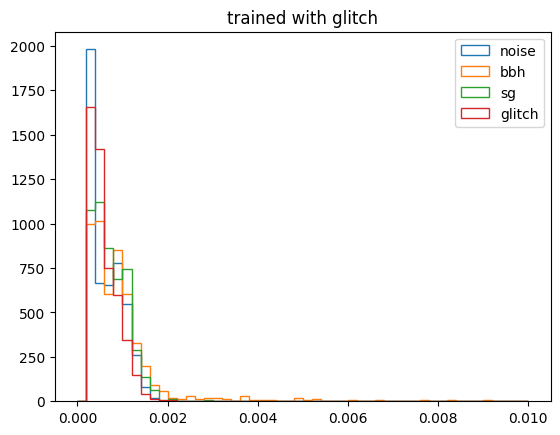

In [ ]:
dcd_bkg = classifier(torch.FloatTensor(realbkg_reserved)).detach().numpy().reshape(-1,200)
dcd_bbh = classifier(torch.FloatTensor(realbbh_reserved)).detach().numpy().reshape(-1,200)
dcd_sg = classifier(torch.FloatTensor(realsg_reserved)).detach().numpy().reshape(-1,200)
dcd_glitch = classifier(torch.FloatTensor(realglitch_reserved)).detach().numpy().reshape(-1,200)

foo = plt.hist(np.var(realbkg_reserved.reshape(-1,200)-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
foo = plt.hist(np.var(realbbh_reserved.reshape(-1,200)-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
foo = plt.hist(np.var(realsg_reserved.reshape(-1,200)-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
foo = plt.hist(np.var(realglitch_reserved.reshape(-1,200)-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
plt.title("trained with glitch")
# plt.axvline(c0["glitch"], color="k", linestyle="--")
plt.legend()

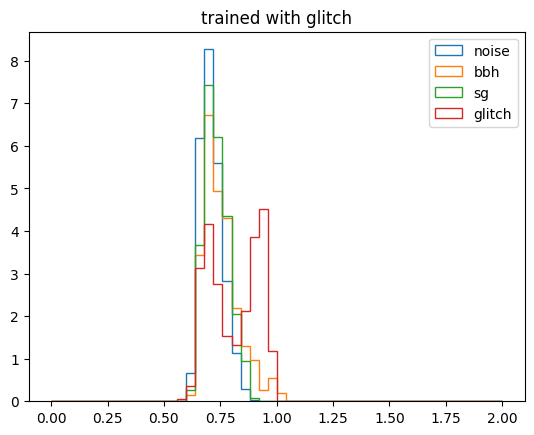

In [97]:
# One channel for DNN
classifier.cpu()

dcd_bkg = classifier(torch.FloatTensor(realbkg_reserved)).detach().numpy().reshape(-1,400)
dcd_bbh = classifier(torch.FloatTensor(realbbh_reserved)).detach().numpy().reshape(-1,400)
dcd_sg = classifier(torch.FloatTensor(realsg_reserved)).detach().numpy().reshape(-1,400)
dcd_glitch = classifier(torch.FloatTensor(realglitch_reserved)).detach().numpy().reshape(-1,400)

foo = plt.hist(np.var(realbkg_reserved.reshape(-1,400)-dcd_bkg, axis=1), histtype="step", range=(0, 2), bins=50, density=True, label="noise")
foo = plt.hist(np.var(realbbh_reserved.reshape(-1,400)-dcd_bbh, axis=1), histtype="step", range=(0, 2), bins=50, density=True, label="bbh")
foo = plt.hist(np.var(realsg_reserved.reshape(-1,400)-dcd_sg, axis=1), histtype="step", range=(0, 2), bins=50, density=True, label="sg")
foo = plt.hist(np.var(realglitch_reserved.reshape(-1,400)-dcd_glitch, axis=1), histtype="step", range=(0, 2), bins=50, density=True, label="glitch")
plt.title("trained with glitch")
# plt.axvline(c0["glitch"], color="k", linestyle="--")
plt.legend()

### Noise trained

In [266]:
version = 'v3'

In [267]:
classifier = torch.load("../Model_cached/Wavelet_model_AE"+version+"_GWAK_trained.pt")

In [269]:
classifier.cpu()

WaveletCNNAE(
  (cap_norm): GroupNorm(2, 2, eps=1e-05, affine=True)
  (Conv_In_encode): Conv1d(2, 4, kernel_size=(1,), stride=(1,))
  (Conv_Out_encode): Conv1d(4, 1, kernel_size=(1,), stride=(1,))
  (Conv_In_decode): Conv1d(1, 4, kernel_size=(1,), stride=(1,))
  (Conv_Out_decode): Conv1d(4, 2, kernel_size=(1,), stride=(1,))
  (body_norm_encode): GroupNorm(4, 4, eps=1e-05, affine=True)
  (body_norm_decode): GroupNorm(4, 4, eps=1e-05, affine=True)
  (end_norm_encode): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (end_norm_decode): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (WaveNet_layers_encode): ModuleList(
    (0): Conv1d(4, 4, kernel_size=(2,), stride=(1,))
    (1): Conv1d(4, 4, kernel_size=(2,), stride=(1,), dilation=(2,))
    (2): Conv1d(4, 4, kernel_size=(2,), stride=(1,), dilation=(4,))
    (3): Conv1d(4, 4, kernel_size=(2,), stride=(1,), dilation=(8,))
    (4): Conv1d(4, 4, kernel_size=(2,), stride=(1,), d

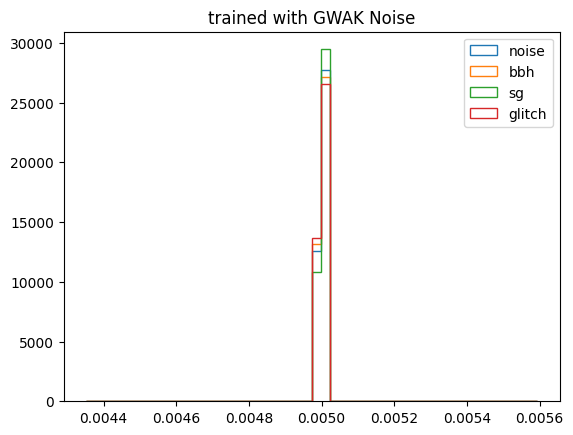

In [270]:
# Noise version 3, GWAK noise, one channel

dcd_bkg = classifier(torch.FloatTensor(realbkg_reserved)).detach().numpy().reshape(-1,400)
dcd_bbh = classifier(torch.FloatTensor(realbbh_reserved)).detach().numpy().reshape(-1,400)
dcd_sg = classifier(torch.FloatTensor(realsg_reserved)).detach().numpy().reshape(-1,400)
dcd_glitch = classifier(torch.FloatTensor(realglitch_reserved)).detach().numpy().reshape(-1,400)

err_bkg = np.var(realbkg_reserved.reshape(-1,400)-dcd_bkg, axis=1)
err_bbh = np.var(realbbh_reserved.reshape(-1,400)-dcd_bbh, axis=1)
err_sg = np.var(realsg_reserved.reshape(-1,400)-dcd_sg, axis=1)
err_glitch = np.var(realglitch_reserved.reshape(-1,400)-dcd_glitch, axis=1)

upper_bound = max(err_bkg.max(),err_bbh.max(),err_sg.max(),err_glitch.max()) * 1.1
lower_bound = min(err_bkg.min(),err_bbh.min(),err_sg.min(),err_glitch.min()) * 0.9

# upper_bound = max(err_bkg.max(),err_bbh.max(),err_sg.max(),err_glitch.max())
# lower_bound = min(err_bkg.min(),err_bbh.min(),err_sg.min(),err_glitch.min())

foo = plt.hist(err_bkg, histtype="step", range=(lower_bound, upper_bound), bins=50, density=True, label="noise")
foo = plt.hist(err_bbh, histtype="step", range=(lower_bound, upper_bound), bins=50, density=True, label="bbh")
foo = plt.hist(err_sg, histtype="step", range=(lower_bound, upper_bound), bins=50, density=True, label="sg")
foo = plt.hist(err_glitch, histtype="step", range=(lower_bound, upper_bound), bins=50, density=True, label="glitch")
plt.title("trained with GWAK Noise")
# plt.axvline(c0["glitch"], color="k", linestyle="--")
plt.legend()

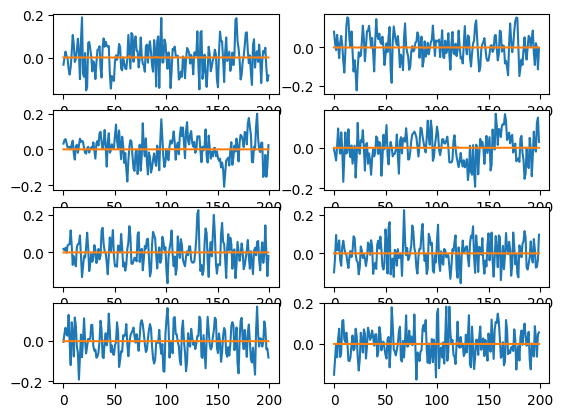

In [275]:
# Noise version 3, GWAK noise, one channel, reconstruction waveform comparison

Reconstructed_Waveforms = {}
Initial_waveforms = {}

datatype_list = ['bkg', 'bbh', 'sg', 'glitch']

Reconstructed_Waveforms['bkg'] = classifier(torch.FloatTensor(realbkg_reserved)).detach().numpy()
Reconstructed_Waveforms['bbh'] = classifier(torch.FloatTensor(realbbh_reserved)).detach().numpy()
Reconstructed_Waveforms['sg'] = classifier(torch.FloatTensor(realsg_reserved)).detach().numpy()
Reconstructed_Waveforms['glitch'] = classifier(torch.FloatTensor(realglitch_reserved)).detach().numpy()

Initial_waveforms['bkg'] = realbkg_reserved
Initial_waveforms['bbh'] = realbbh_reserved
Initial_waveforms['sg'] = realsg_reserved
Initial_waveforms['glitch'] = realglitch_reserved

bkg_idx = 0
bbh_idx = 0
sg_idx = 0
glitch_idx = 0

idx = {'bkg':bkg_idx,
       'bbh':bbh_idx,
       'sg':sg_idx,
       'glitch':glitch_idx
       }

fig, axs = plt.subplots(4,2)

for j in range(len(datatype_list)):
    for i in range(2):
        axs[j,i].plot(Initial_waveforms[datatype_list[j]][idx[datatype_list[j]]][i])
        axs[j,i].plot(Reconstructed_Waveforms[datatype_list[j]][idx[datatype_list[j]]][i])
plt.show()


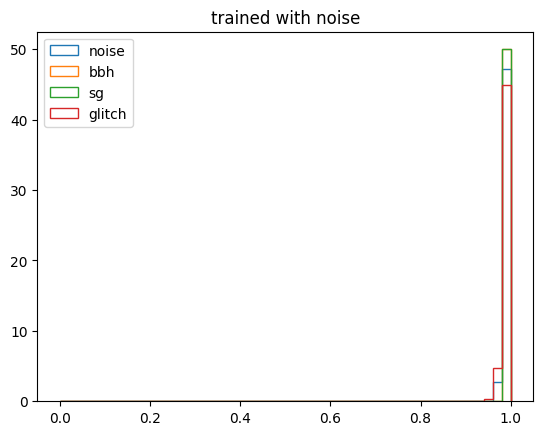

In [106]:
# Noise version 1, one channel for DNN

dcd_bkg = classifier(torch.FloatTensor(realbkg_reserved)).detach().numpy().reshape(-1,400)
dcd_bbh = classifier(torch.FloatTensor(realbbh_reserved)).detach().numpy().reshape(-1,400)
dcd_sg = classifier(torch.FloatTensor(realsg_reserved)).detach().numpy().reshape(-1,400)
dcd_glitch = classifier(torch.FloatTensor(realglitch_reserved)).detach().numpy().reshape(-1,400)

foo = plt.hist(np.var(realbkg_reserved.reshape(-1,400)-dcd_bkg, axis=1), histtype="step", range=(0, 1), bins=50, density=True, label="noise")
foo = plt.hist(np.var(realbbh_reserved.reshape(-1,400)-dcd_bbh, axis=1), histtype="step", range=(0, 1), bins=50, density=True, label="bbh")
foo = plt.hist(np.var(realsg_reserved.reshape(-1,400)-dcd_sg, axis=1), histtype="step", range=(0, 1), bins=50, density=True, label="sg")
foo = plt.hist(np.var(realglitch_reserved.reshape(-1,400)-dcd_glitch, axis=1), histtype="step", range=(0, 1), bins=50, density=True, label="glitch")
plt.title("trained with noise")
# plt.axvline(c0["glitch"], color="k", linestyle="--")
plt.legend()

In [29]:
np.var(realbkg_reserved.reshape(-1,200)-dcd_bkg, axis=1)

array([0.02201537, 0.05003922, 0.02644901, ..., 0.05077039, 0.02142253,
       0.05276636])

### BBH trained

In [ ]:
version = 'v1'

In [242]:
classifier = torch.load("../Model_cached/Wavelet_model_AE"+version+"_GWAK_BBH_trained.pt")

In [243]:
classifier.cpu()

WaveletCNNAE(
  (cap_norm): GroupNorm(2, 2, eps=1e-05, affine=True)
  (Conv_In_encode): Conv1d(2, 4, kernel_size=(1,), stride=(1,))
  (Conv_Out_encode): Conv1d(4, 1, kernel_size=(1,), stride=(1,))
  (Conv_In_decode): Conv1d(1, 4, kernel_size=(1,), stride=(1,))
  (Conv_Out_decode): Conv1d(4, 2, kernel_size=(1,), stride=(1,))
  (body_norm_encode): GroupNorm(4, 4, eps=1e-05, affine=True)
  (body_norm_decode): GroupNorm(4, 4, eps=1e-05, affine=True)
  (end_norm_encode): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (end_norm_decode): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (WaveNet_layers_encode): ModuleList(
    (0): Conv1d(4, 4, kernel_size=(2,), stride=(1,))
    (1): Conv1d(4, 4, kernel_size=(2,), stride=(1,), dilation=(2,))
    (2): Conv1d(4, 4, kernel_size=(2,), stride=(1,), dilation=(4,))
    (3): Conv1d(4, 4, kernel_size=(2,), stride=(1,), dilation=(8,))
    (4): Conv1d(4, 4, kernel_size=(2,), stride=(1,), d

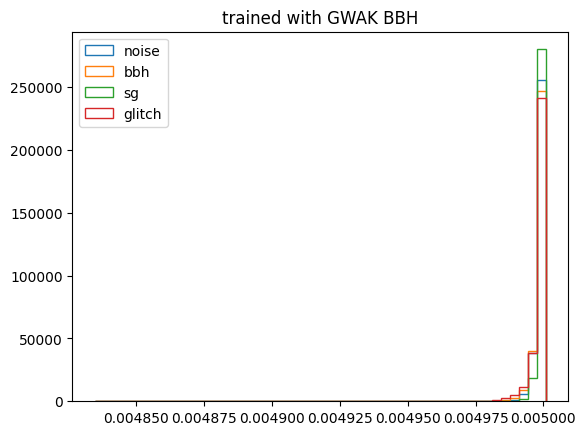

In [264]:
# BBH version 1, GWAK BBH, one channel

dcd_bkg = classifier(torch.FloatTensor(realbkg_reserved)).detach().numpy().reshape(-1,400)
dcd_bbh = classifier(torch.FloatTensor(realbbh_reserved)).detach().numpy().reshape(-1,400)
dcd_sg = classifier(torch.FloatTensor(realsg_reserved)).detach().numpy().reshape(-1,400)
dcd_glitch = classifier(torch.FloatTensor(realglitch_reserved)).detach().numpy().reshape(-1,400)

err_bkg = np.var(realbkg_reserved.reshape(-1,400)-dcd_bkg, axis=1)
err_bbh = np.var(realbbh_reserved.reshape(-1,400)-dcd_bbh, axis=1)
err_sg = np.var(realsg_reserved.reshape(-1,400)-dcd_sg, axis=1)
err_glitch = np.var(realglitch_reserved.reshape(-1,400)-dcd_glitch, axis=1)

upper_bound = max(err_bkg.max(),err_bbh.max(),err_sg.max(),err_glitch.max()) * 1.1
lower_bound = min(err_bkg.min(),err_bbh.min(),err_sg.min(),err_glitch.min()) * 0.9

# upper_bound = max(err_bkg.max(),err_bbh.max(),err_sg.max(),err_glitch.max())
# lower_bound = min(err_bkg.min(),err_bbh.min(),err_sg.min(),err_glitch.min())

foo = plt.hist(err_bkg, histtype="step", range=(lower_bound, upper_bound), bins=50, density=True, label="noise")
foo = plt.hist(err_bbh, histtype="step", range=(lower_bound, upper_bound), bins=50, density=True, label="bbh")
foo = plt.hist(err_sg, histtype="step", range=(lower_bound, upper_bound), bins=50, density=True, label="sg")
foo = plt.hist(err_glitch, histtype="step", range=(lower_bound, upper_bound), bins=50, density=True, label="glitch")
plt.title("trained with GWAK BBH")
# plt.axvline(c0["glitch"], color="k", linestyle="--")
plt.legend()

In [97]:
classifier.cpu()

WaveletCNNAE(
  (cap_norm): GroupNorm(1, 1, eps=1e-05, affine=True)
  (Conv_In_encode): Conv1d(1, 4, kernel_size=(1,), stride=(1,))
  (Conv_Out_encode): Conv1d(4, 1, kernel_size=(1,), stride=(1,))
  (Conv_In_decode): Conv1d(1, 4, kernel_size=(1,), stride=(1,))
  (Conv_Out_decode): Conv1d(4, 1, kernel_size=(1,), stride=(1,))
  (body_norm_encode): GroupNorm(4, 4, eps=1e-05, affine=True)
  (body_norm_decode): GroupNorm(4, 4, eps=1e-05, affine=True)
  (end_norm_encode): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (end_norm_decode): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (WaveNet_layers_encode): ModuleList(
    (0): Conv1d(4, 4, kernel_size=(2,), stride=(1,))
    (1): Conv1d(4, 4, kernel_size=(2,), stride=(1,), dilation=(2,))
    (2): Conv1d(4, 4, kernel_size=(2,), stride=(1,), dilation=(4,))
    (3): Conv1d(4, 4, kernel_size=(2,), stride=(1,), dilation=(8,))
    (4): Conv1d(4, 4, kernel_size=(2,), stride=(1,), d